# Haplotype analysis *Rdl*

## Input

Input files:

In [1]:
# output
outdir   = "haplotype_analysis_output"
outcode  = "rdo_hapnet"

# gene of interest
chrom     = "2L"
l_nom     = "rdl"    # nom loci
loc_start = 25363652 # start gene
loc_end   = 25434556 # end gene
popc      = "population"

# inversion 2La
inv_start = 20524058 # interval 20524058 - 20528089
inv_end   = 42165532 # interval 42165182 - 42165532

# retain all data between these coordinates, to ease up on memory
ret_start  = loc_start-1e6
ret_end    = loc_end+1e6
ret_start  = 0  
ret_end    = 50000000

# min frq to retain minor allele
minfrq     = 0.05
# input data phase2
p2_metasam_fn = "data/samples_p2.meta.txt"
p2_hapcall_fn = "/home/xavi/Documents/VariationAg1k/data/phase2.AR1/haplotypes/zarr2/ag1000g.phase2.ar1.samples/"  #### EDIT THIS 
p2_accessi_fn = "/home/xavi/Documents/VariationAg1k/data/phase2.AR1/accessibility/accessibility.h5"                #### EDIT THIS
p2_popc       = popc
p2_popl       = ["AOcol","BFcol","BFgam","CIcol","CMgam","FRgam","GAgam","GHcol","GHgam","GM","GNcol","GNgam","GQgam","GW","KE","UGgam"]

# outgroup populations
ou_species    = ["arab","quad","meru","mela"]
ou_hapcall_fl = ["/home/xavi/dades/Variation/phase1.AR3_Fontaine_AltSps/haplotypes/arab_ref_hc_vqsr_cnvrt_sort.zarr/",       #### EDIT THIS
                 "/home/xavi/dades/Variation/phase1.AR3_Fontaine_AltSps/haplotypes/quad_ref_hc_vqsr_cnvrt_sort.zarr/",       #### EDIT THIS
                 "/home/xavi/dades/Variation/phase1.AR3_Fontaine_AltSps/haplotypes/meru_hc_vqsr_cnvrt_sort.zarr/",           #### EDIT THIS
                 "/home/xavi/dades/Variation/phase1.AR3_Fontaine_AltSps/haplotypes/mela_ref_hc_vqsr_good_cnvrt_sort.zarr/"]  #### EDIT THIS
ou_metasam_fl = ["data/samples.metaara.txt",
                 "data/samples.metaqua.txt",
                 "data/samples.metamer.txt",
                 "data/samples.metamel.txt"]
ou_popc       = popc

# karyotype data
kary_fn    = "data/kt_2la.karyotype_with_outgroups.csv"
# accessibility phase2
accessi_fn = "/home/xavi/Documents/VariationAg1k/data/phase2.AR1/accessibility/accessibility.h5" #### EDIT THIS
# snp effects
snpeff_fn  = "/home/xavi/Documents/VariationAg1k/data/phase2.AR1/snpeff/zarr2/"                  #### EDIT THIS
# gff
gffann_fn  = "data/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.9.gff3"

In [2]:
import numpy as np
import zarr
import pandas as pd
import allel
import h5py
import warnings
import scipy
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm
import seaborn as sns
import itertools
from mlxtend.evaluate import permutation_test
warnings.simplefilter('ignore')
import random

%run scripts_hapclust/hapclust.py

# load plot settings
sns.set(context="notebook",style="ticks",
        font_scale=1,font="Arial",palette="bright")

Color palette for networks (must be named!):

In [3]:
# define dictionary of pop colors
pop_colors = {
 'AOcol' : "forestgreen",
 'BFcol' : "red",
 'BFgam' : "springgreen",
 'CIcol' : "dodgerblue",
 'CMgam' : "orange",
 'FRgam' : "magenta",
 'GAgam' : "blueviolet",
 'GHcol' : "yellowgreen",
 'GHgam' : "deeppink",
 'GM'    : "cyan",
 'GNcol' : "peru",
 'GNgam' : "turquoise",
 'GQgam' : "sienna",
 'GW'    : "gold",
 'KE'    : "steelblue",
 'UGgam' : "violet",
 'CMara' : "slategray",
 'BFara' : "slategray",
 'TZara' : "slategray",
 'ZMqua' : "gray",
 'SAmer' : "gray",
 'KEmer' : "gray",
 'CMmel' : "gray",
}
pos_colors = {
 'AOcol' : "red",
 'BFcol' : "red",
 'BFgam' : "green",
 'CIcol' : "red",
 'CMgam' : "green",
 'FRgam' : "green",
 'GAgam' : "green",
 'GHcol' : "red",
 'GHgam' : "green",
 'GM'    : "blue",
 'GNcol' : "red",
 'GNgam' : "green",
 'GQgam' : "green",
 'GW'    : "blue",
 'KE'    : "blue",
 'UGgam' : "green",
 'CMara' : "orange",
 'BFara' : "orange",
 'TZara' : "orange",
 'ZMqua' : "gray",
 'SAmer' : "slategray",
 'KEmer' : "lightgray",
 'CMmel' : "steelblue",
}

var_colors = dict({
    -1 : "orange",
    0  : "lightgray",
    1  : "deepskyblue",
    2  : "blue",
    3  : "violet",
})


## Load data

### Phase2 variants

Population and sample data:

In [4]:
# load samples list with sample code, groupings, locations etc.
p2_samples_df   = pd.read_csv(p2_metasam_fn, sep='\t')
p2_samples_bool = (p2_samples_df[p2_popc].isin(p2_popl).values)
p2_samples      = p2_samples_df[p2_samples_bool]
p2_samples.reset_index(drop=True, inplace=True)

# indexed dictionary of populations
p2_popdict = dict()
for popi in p2_popl: 
    p2_popdict[popi]  = p2_samples[p2_samples[p2_popc] == popi].index.tolist()

# add an extra population composed of all other locations
p2_popdict["all"] = []
for popi in p2_popl:
    p2_popdict["all"] = p2_popdict["all"] + p2_popdict[popi]


# report
print("Data:")
print("* Samples     = ", p2_samples.shape[0])
print("* Populations = ", set(p2_samples[p2_popc]))
print(p2_samples.groupby(("population")).size())

Data:
* Samples     =  1142
* Populations =  {'UGgam', 'GW', 'FRgam', 'BFgam', 'GAgam', 'GNgam', 'GHgam', 'GQgam', 'GNcol', 'KE', 'BFcol', 'GM', 'CIcol', 'CMgam', 'GHcol', 'AOcol'}
population
AOcol     78
BFcol     75
BFgam     92
CIcol     71
CMgam    297
FRgam     24
GAgam     69
GHcol     55
GHgam     12
GM        65
GNcol      4
GNgam     40
GQgam      9
GW        91
KE        48
UGgam    112
dtype: int64


Phased variants and genotypes:

In [5]:
# declare objects with variant data
p2_hapcall   = zarr.open(p2_hapcall_fn)
# variants of genotypes
print("Variants phased...")
p2_hapcall_var = p2_hapcall[chrom]["variants"]
p2_hapvars = allel.VariantChunkedTable(p2_hapcall_var,names=["POS","REF","ALT"],index="POS") 
print(p2_hapvars.shape)
# genotype data
print("Genotypes phased...")
p2_hapcall_hap = p2_hapcall[chrom]["calldata"]["genotype"]
p2_haploty     = allel.GenotypeChunkedArray(p2_hapcall_hap) 
p2_haploty     = p2_haploty.subset(sel1=p2_samples_bool)
print(p2_haploty.shape)

Variants phased...
(8906423,)
Genotypes phased...
(8906423, 1142, 2)


Subsetting step specific to this analysis: remove variants outside of this region to ease up on memory. If this block is excluded, everything works as usual.

In [6]:
# phased
print("Subset phased variants to region...")
pos_booh   = np.logical_and(p2_hapvars["POS"] >= ret_start, p2_hapvars["POS"] <= ret_end)
p2_hapvars = p2_hapvars.compress(pos_booh)
p2_haploty = p2_haploty.subset(sel0=pos_booh)
print(p2_haploty.shape)

Subset phased variants to region...
(8906423, 1142, 2)


Where does this start and end?

In [7]:
print("Phased variants:",p2_hapvars["POS"][0],"-",p2_hapvars["POS"][-1])

Phased variants: 25050 - 49356429


### Outgroups

Loads one outgroup, removes indels (duplicated variant positions) and subsets phase2 to include variants present in this outgroup. Then, loads outgroup genotypes and subsets them to remove indels and fit phase2. Then, loads the second outgroup and performs the same task. Thus, at each iteration, less and less variants remain (hopefully not too many are lost; worst offenders are `chri` and `epir`).

In [8]:
def remove_indels(gt, ref, alt, pos):
    """This removes indels from the Fontaine data
    https://github.com/SeanTomlinson30/phd-ops/blob/master/218-arabiensis-aim/20181127-fontaine-data-munging.ipynb"""
    # Utility
    mylen = np.vectorize(len)
    # ALT
    count_alt = mylen(alt)
    alt_count = np.sum(count_alt, axis=1)
    # This array returns true at each position if the alt is fixed for the reference or has only one alternate allele.
    is_ref_or_snp = alt_count <= 1
    # REF Let's pull out the positions where it's a single base
    length_of_ref = mylen(ref) <= 1 
    # return the logical and of these 2 arrays this removes the second instance of a duplicated position
    is_not_dup = np.concatenate([[True], np.diff(pos) > 0])
    # this is the final bool array to filter the data with, and results in positions that are not multiallelic not containing indel and not containing duplicated positions
    bool_mask = length_of_ref & is_ref_or_snp & is_not_dup
    return(bool_mask)
    print('DONE')

In [9]:
oc_haploty = p2_haploty
oc_hapvars = p2_hapvars

for outn,outi in enumerate(ou_species):
    
    print("# p2 phased genotypes remaining: %i" % oc_haploty.shape[0])
    
    # Variants
    print("Variants phased %s..." % outi)
    ou_hapcall = zarr.open(ou_hapcall_fl[outn])
    ou_hapvars = allel.VariantChunkedTable(ou_hapcall[chrom]["variants"],names=["POS","REF","ALT"],index="POS")

    # retain positions in inversion & remove indels
    print("Remove indel phased %s..." % outi)
    pos_noindeh = remove_indels(gt = ou_hapcall[chrom]["calldata"]["GT"], ref = ou_hapcall[chrom]["variants"]["REF"], alt = ou_hapcall[chrom]["variants"]["ALT"], pos = ou_hapvars["POS"])
    ou_hapvars  = ou_hapvars[:][pos_noindeh]
    
    # subset phase2 to fit phase1
    print("Subset phased phase2 to %s..." % outi)
    is_p2_ih_ou = np.isin(oc_hapvars["POS"],test_elements=ou_hapvars["POS"])
    oc_haploty  = oc_haploty.compress((is_p2_ih_ou))
    oc_hapvars  = oc_hapvars.compress((is_p2_ih_ou))
    print(oc_haploty.shape)
    
    # genotype data
    print("Genotypes phased %s..." % outi)
    ou_haploty     = allel.GenotypeChunkedArray(ou_hapcall[chrom]["calldata"]["GT"]).compress(pos_noindeh)
    
    # retain positions available in phase2
    print("Subset phased %s to phase2..." % outi)
    ih_ou_in_p2 = np.isin(ou_hapvars["POS"],test_elements=oc_hapvars["POS"])
    ou_haploty  = ou_haploty.compress(ih_ou_in_p2)
    print(ou_haploty.shape)

    # add new genotypes to phase2
    print("Merge phased %s into phase2..." % outi)
    oc_haploty = oc_haploty.concatenate(ou_haploty,axis=1)
    print(oc_haploty.shape)
    
    del ou_haploty
    del ou_hapvars

# p2 phased genotypes remaining: 8906423
Variants phased arab...
Remove indel phased arab...
Subset phased phase2 to arab...
(8476972, 1142, 2)
Genotypes phased arab...
Subset phased arab to phase2...
(8476972, 12, 2)
Merge phased arab into phase2...
(8476972, 1154, 2)
# p2 phased genotypes remaining: 8476972
Variants phased quad...
Remove indel phased quad...
Subset phased phase2 to quad...
(8280012, 1154, 2)
Genotypes phased quad...
Subset phased quad to phase2...
(8280012, 10, 2)
Merge phased quad into phase2...
(8280012, 1164, 2)
# p2 phased genotypes remaining: 8280012
Variants phased meru...
Remove indel phased meru...
Subset phased phase2 to meru...
(8089824, 1164, 2)
Genotypes phased meru...
Subset phased meru to phase2...
(8089824, 10, 2)
Merge phased meru into phase2...
(8089824, 1174, 2)
# p2 phased genotypes remaining: 8089824
Variants phased mela...
Remove indel phased mela...
Subset phased phase2 to mela...
(7775146, 1174, 2)
Genotypes phased mela...
Subset phased mela to

Expand phase of phased variants:

In [10]:
# recast haplotypes: drop ploidy
print("Expand phase haplotypes...")
oc_haploty_hap = oc_haploty.to_haplotypes()
print(oc_haploty_hap.shape)

Expand phase haplotypes...
(7775146, 2356)


### Merge sample data

Merge metadata files, with sample codes, species and populations, for variants:

In [11]:
print("Cast sample metadata...")
oc_samples = pd.DataFrame(data={
    "ox_code"    :  p2_samples["ox_code"].values.tolist() + 
                    list(itertools.chain.from_iterable([ pd.read_csv(ou_metasam_fl[n], sep='\t')["ox_code"].values.tolist()  for n,i in enumerate(ou_species) ])),
    "species"    :  p2_samples["m_s"].values.astype(str).tolist() + 
                    list(itertools.chain.from_iterable([ pd.read_csv(ou_metasam_fl[n], sep='\t')["species"].values.tolist()  for n,i in enumerate(ou_species) ])),
    "population" :  p2_samples[p2_popc].values.tolist()   + 
                    list(itertools.chain.from_iterable([ pd.read_csv(ou_metasam_fl[n], sep='\t')[ou_popc].values.tolist()  for n,i in enumerate(ou_species) ]))
})
print(oc_samples.shape)

# rename species...
oc_samples["species"].values[oc_samples["species"].values == "M"]   = "col"
oc_samples["species"].values[oc_samples["species"].values == "S"]   = "gam"
oc_samples["species"].values[oc_samples["species"].values == "M/S"] = "gamcol"
oc_samples["species"].values[oc_samples["species"].values == "M-S"] = "gamcol"
oc_samples["species"].values[oc_samples["species"].values == "nan"] = "gamcol"

# obtain full population & species list
oc_popl = np.unique(oc_samples["population"].values)
oc_spsl = np.unique(oc_samples["species"].values)

Cast sample metadata...
(1178, 3)


Merge metadata files, with sample codes, species and populations, for expanded phased variants:

In [12]:
print("Cast sample metadata...")
oc_sampleh = pd.DataFrame(data={
    "ox_code"    :  list(itertools.chain(*[[ s + 'a', s + 'b'] for s in oc_samples["ox_code"].values.tolist()])),    # takes col from oc_samples and duplicates it, a/b
    "species"    :  list(itertools.chain(*[[ s      , s      ] for s in oc_samples["species"].values.tolist()])),
    "population" :  list(itertools.chain(*[[ s      , s      ] for s in oc_samples["population"].values.tolist()]))
})
print(oc_sampleh.shape)

Cast sample metadata...
(2356, 3)


Dictionaries of populations and species:

In [13]:
print("Population dict...")
oc_popdict = dict()
for popi in oc_popl: 
    oc_popdict[popi]  = oc_samples[oc_samples["population"] == popi].index.tolist()
oc_popdict["all"] = []
for popi in oc_popl:
    oc_popdict["all"] = oc_popdict["all"] + oc_popdict[popi]

print("Population dict phased...")
oc_popdich = dict()
for popi in oc_popl: 
    oc_popdich[popi]  = oc_sampleh[oc_sampleh["population"] == popi].index.tolist()
oc_popdich["all"] = []
for popi in oc_popl:
    oc_popdich["all"] = oc_popdich["all"] + oc_popdich[popi]

print("Species dict...")
oc_spsdict = dict()
for spsi in oc_spsl: 
    oc_spsdict[spsi]  = oc_samples[oc_samples["species"] == spsi].index.tolist()
    
print("Species dict phased...")
oc_spsdich = dict()
for spsi in oc_spsl: 
    oc_spsdich[spsi]  = oc_sampleh[oc_sampleh["species"] == spsi].index.tolist()

Population dict...
Population dict phased...
Species dict...
Species dict phased...


### Allele counts

Using both dictionaries:

In [14]:
print("Genotypes phased to allele counts (population)...")
oc_hapalco_pop = oc_haploty.count_alleles_subpops(subpops=oc_popdict)
print(oc_hapalco_pop.shape)

print("Haplotypes phased to allele counts (population)...")
oc_hapalco_hap_pop = oc_haploty_hap.count_alleles_subpops(subpops=oc_popdich)
print(oc_hapalco_hap_pop.shape)

Genotypes phased to allele counts (population)...
(7775146,)
Haplotypes phased to allele counts (population)...
(7775146,)


Define which phased variants to retain from phase2 (all other datasets will be recast to fit this):

In [15]:
# subset data: segregating alleles, biallelic and no singletons
print("Filters phased p2+ou...")
oc_is_seg_h    = oc_hapalco_hap_pop["all"].is_segregating()[:] # segregating
oc_is_nosing_h = oc_hapalco_hap_pop["all"][:,:2].min(axis=1)>2 # no singletons

# subset phase2 to seg, nosing, biallelic & outgroup size
oc_hapvars_seg         = oc_hapvars.compress((oc_is_seg_h[:] & oc_is_nosing_h[:]))
oc_haploty_seg         = oc_haploty.compress((oc_is_seg_h[:] & oc_is_nosing_h[:]))
oc_hapalco_pop_seg     = oc_hapalco_pop.compress((oc_is_seg_h[:] & oc_is_nosing_h[:]))
oc_haploty_hap_seg     = oc_haploty_hap.compress((oc_is_seg_h[:] & oc_is_nosing_h[:]))
oc_hapalco_hap_pop_seg = oc_hapalco_hap_pop.compress((oc_is_seg_h[:] & oc_is_nosing_h[:]))

# report
print(oc_haploty_seg.shape,"/", oc_haploty.shape)

Filters phased p2+ou...
(4631559, 1178, 2) / (7775146, 1178, 2)


### Other data

Accessibility:

In [16]:
# Accessibility
print("Load accessibility array...")
accessi_df  = h5py.File(accessi_fn,mode="r")
accessi_arr = accessi_df[chrom]["is_accessible"][:]

Load accessibility array...


Gene annotations GFF:

In [17]:
# import gff
def geneset_gff(geneset):
    items = []
    for n in geneset.dtype.names:
        v = geneset[n]
        if v.dtype.kind == 'S':
            v = v.astype('U')
        items.append((n, v))
    return pd.DataFrame.from_items(items)
%run scripts_printtranscripts/allel_printtranscripts_24gen18.py

geneset = allel.FeatureTable.from_gff3(gffann_fn,attributes=['ID', 'Parent'])
geneset = geneset_gff(geneset)


In [18]:
geneset[geneset["Parent"] == "AGAP006028"]

,seqid,source,type,start,end,score,strand,phase,ID,Parent
20674,2L,VectorBase,mRNA,25363652,25434556,-1.0,+,-1,AGAP006028-RA,AGAP006028
20693,2L,VectorBase,mRNA,25363652,25434556,-1.0,+,-1,AGAP006028-RB,AGAP006028
20712,2L,VectorBase,mRNA,25363652,25434556,-1.0,+,-1,AGAP006028-RC,AGAP006028


Variant effects:

In [19]:
# load
print("Load variant effects...")
snpeff_zr          = zarr.open(snpeff_fn)
oc_genveff         = allel.VariantChunkedTable(snpeff_zr[chrom]["variants"],names=["POS","ANN"],index="POS") # variant effects
is_ef_in_oc        = np.isin(oc_genveff["POS"],test_elements=oc_hapvars_seg["POS"])
oc_genveff_seg_ann = oc_genveff["ANN"][:][is_ef_in_oc]
oc_genveff_seg_pos = oc_genveff["POS"][:][is_ef_in_oc]

# variant effect name array: full name
print("Variant name array...")
oc_snpname_seg     = np.array(
    [chrom+":"+x1+" "+x2 for x1,x2 in zip(
        np.asarray(oc_genveff_seg_pos.astype(str)),
        np.asarray([oc_genveff_seg_ann[i].split("|")[10] for i,_ in enumerate(oc_genveff_seg_ann)]))
    ])
oc_snpname_seg = np.array([i.replace("p.","") for i in oc_snpname_seg])

# variant effect name array: coding only
oc_snpname_seg_cod = np.array(np.asarray([oc_genveff_seg_ann[i].split("|")[10] for i,_ in enumerate(oc_genveff_seg_ann)]))
oc_snpname_seg_cod = np.array([i.replace("p.","") for i in oc_snpname_seg_cod])
# report
print(oc_snpname_seg.shape,oc_snpname_seg_cod.shape)

Load variant effects...
Variant name array...
(4631559,) (4631559,)


Is variant above certain minimum frequency? 

In [20]:
# allele counts table per pop
co_major = pd.DataFrame() 
co_minor = pd.DataFrame()
fq_minor = pd.DataFrame()
for popi in oc_popl: 
    co_major[popi] = oc_hapalco_pop_seg[popi][:,0]
    co_minor[popi] = oc_hapalco_pop_seg[popi][:,1]
    fq_minor[popi] = oc_hapalco_pop_seg[popi][:,1] / oc_hapalco_pop_seg[popi][:,0:2].sum(axis=1)
co_major["all"] = co_major.sum(axis=1)
co_minor["all"] = co_minor.sum(axis=1)
fq_minor["all"] = co_minor.sum(axis=1) / (co_minor.sum(axis=1)+co_major.sum(axis=1))

# subset data: keep variants with at least 5% freq in at least one pop
is_minfq  = np.logical_and(fq_minor.max(axis=1) > minfrq, fq_minor.min(axis=1) < 1-minfrq)

Is variant in the loci of interest? (useful for reporting)

In [21]:
is_in_loci = np.logical_and(oc_hapvars_seg["POS"] >= loc_start, oc_hapvars_seg["POS"] <= loc_end)
is_coding  = np.asarray([oc_genveff_seg_ann[i].split("|")[1] == "missense_variant" for i,_ in enumerate(oc_genveff_seg_ann)])
is_report  = (is_in_loci & is_coding & is_minfq)

# report
print("minfrq, in loci and coding:",sum(is_report))
print("in loci:                   ",sum(is_in_loci))

minfrq, in loci and coding: 6
in loci:                    3003


Print table with variants, effects and frequencies:

In [22]:
# print table
fq_repor = pd.DataFrame(data={
    "chr"      : [chrom] * co_minor[is_in_loci].shape[0],
    "POS"      : oc_hapvars_seg["POS"].subset(sel0=is_in_loci)[:].astype(str),
    "REF"      : oc_hapvars_seg["REF"].subset(sel0=is_in_loci)[:].astype(str),
    "ALT"      : oc_hapvars_seg["ALT"].subset(sel0=is_in_loci)[:].astype(str),
    "is_nonsyn": is_coding[is_in_loci],
    "gene_eff" : [oc_genveff_seg_ann.compress(is_in_loci)[i].split("|")[3]  for i,_ in enumerate(oc_genveff_seg_ann.compress(is_in_loci))],
    "PEP_eff"  : [oc_genveff_seg_ann.compress(is_in_loci)[i].split("|")[10] for i,_ in enumerate(oc_genveff_seg_ann.compress(is_in_loci))],
    "CDS_eff"  : [oc_genveff_seg_ann.compress(is_in_loci)[i].split("|")[9]  for i,_ in enumerate(oc_genveff_seg_ann.compress(is_in_loci))]
},
columns=["chr","POS","REF","ALT","gene_eff","PEP_eff","CDS_eff","is_nonsyn"]
)
fq_repor = pd.concat([fq_repor,fq_minor[is_in_loci].reset_index()],axis=1)
fq_repor.to_csv("%s/%s_%s.allele_fq.csv" % (outdir,outcode,l_nom),sep="\t",index=False)

Print table with genotypes of key variants, per sample:

In [23]:
# dataframe with pops
gt_repor = pd.DataFrame(data={
    "ox_code"    : oc_samples["ox_code"],
    "population" : oc_samples["population"],
    "species"    : oc_samples["species"],
}
)

# retrieve 012 genotypes for report
gt_gtysa = pd.DataFrame(np.transpose(oc_haploty_seg.subset(sel0=is_report).to_n_alt(fill=-1)))
gt_gtysa.columns = oc_snpname_seg[is_report]

# print
gt_repor = pd.concat([gt_repor, gt_gtysa],axis=1)
gt_repor.to_csv("%s/%s_%s.allele_genotypes.csv" % (outdir,outcode,l_nom),sep="\t",index=False)

Add info from 2La karyotype:

In [24]:
kary_df = pd.read_csv(kary_fn, sep='\t')
kary_df = kary_df.loc[kary_df['population'].isin(oc_popl)]
print("karyotypes 2La phase2:",kary_df.shape)

kary_df_hap = pd.DataFrame(data={
    "ox_code"     : list(itertools.chain(*[[ s + 'a', s + 'b'] for s in kary_df["ox_code"].values.tolist()])),    
    "estimated_kt" : list(itertools.chain(*[[ s      , s      ] for s in kary_df["estimated_kt"].values.tolist()]))
})

kary_df_hap.shape

karyotypes 2La phase2: (1178, 4)


(2356, 2)

## Variant frequency

First, plot frequency of coding variants inside of the gene itself:

Minor allele freqs...


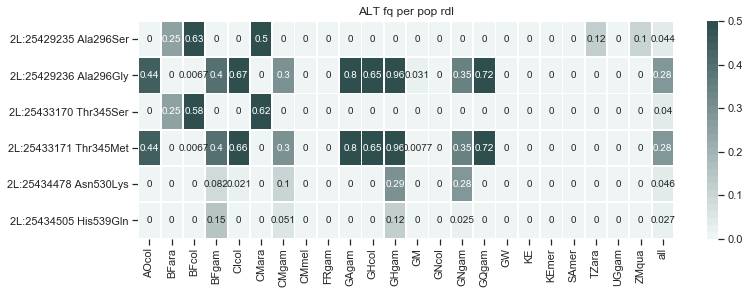

In [25]:
print("Minor allele freqs...")
    
# plot minor allele freqs per pop
fig = plt.figure(figsize=(12,4))
pdf = PdfPages("%s/%s_%s.allele_fq.pdf" % (outdir,outcode,l_nom))

# plot
ax=sns.heatmap(fq_minor[is_report],vmin=0,vmax=0.5,cmap=sns.light_palette("darkslategray",n_colors=31),
               yticklabels=oc_snpname_seg[is_report],linewidths=0.8,linecolor="white",annot=True)
ax.set_title("ALT fq per pop %s" % l_nom)

pdf.savefig(fig,bbox_inches='tight')
pdf.close()

Some variants seem to be linked (co-occurring in the same populations): 296S/345S, and 296G/345M. 

### Hardy-Weinberg

In [26]:
for alli_n,alli in enumerate(["296S","296G"]):
    for popi in ["AOcol","BFcol","CIcol","GHcol","GNcol","BFgam","CMgam","FRgam","GAgam","GHgam","GNgam","GQgam","UGgam","GM","GW","KE","BFara","CMara","TZara",
         "ZMqua","SAmer","KEmer","CMmel"]:

        hw_obs = allel.heterozygosity_observed( g=oc_haploty_seg.subset(sel0=is_report, sel1=oc_popdict[popi]))
        hw_exp = allel.heterozygosity_expected(af=oc_haploty_seg.subset(sel0=is_report, sel1=oc_popdict[popi]).count_alleles().to_frequencies(), ploidy=2)
        hw_inb = allel.inbreeding_coefficient(  g=oc_haploty_seg.subset(sel0=is_report, sel1=oc_popdict[popi]))

        hw_obs_n = hw_obs * len(oc_popdict[popi])
        hw_exp_n = hw_exp * len(oc_popdict[popi])

        print(alli,popi,int(hw_obs_n[alli_n]),hw_exp_n[alli_n])

296S AOcol 0 0.0
296S BFcol 40 35.09333333333333
296S CIcol 0 0.0
296S GHcol 0 0.0
296S GNcol 0 0.0
296S BFgam 0 0.0
296S CMgam 0 0.0
296S FRgam 0 0.0
296S GAgam 0 0.0
296S GHgam 0 0.0
296S GNgam 0 0.0
296S GQgam 0 0.0
296S UGgam 0 0.0
296S GM 0 0.0
296S GW 0 0.0
296S KE 0 0.0
296S BFara 0 1.5
296S CMara 2 2.0
296S TZara 1 0.875
296S ZMqua 2 1.7999999999999994
296S SAmer 0 0.0
296S KEmer 0 0.0
296S CMmel 0 0.0
296G AOcol 38 38.35897435897436
296G BFcol 1 0.9933333333333461
296G CIcol 33 31.443661971830988
296G GHcol 21 25.172727272727272
296G GNcol 0 0.0
296G BFgam 46 44.23913043478261
296G CMgam 121 125.84680134680136
296G FRgam 0 0.0
296G GAgam 23 21.717391304347828
296G GHgam 1 0.9583333333333313
296G GNgam 18 18.2
296G GQgam 5 3.611111111111111
296G UGgam 0 0.0
296G GM 4 3.876923076923081
296G GW 0 0.0
296G KE 0 0.0
296G BFara 0 0.0
296G CMara 0 0.0
296G TZara 0 0.0
296G ZMqua 0 0.0
296G SAmer 0 0.0
296G KEmer 0 0.0
296G CMmel 0 0.0


### Linkage disequilibrium

We calculate the **linkage disequilibrium** between all allele pairs, using two different metrics (Rogers & Huff $r$, Lewontin's $D'$). 

Two functions for Lewontin $D'$:

In [27]:
def lewontin_d_prime(h, i, j, a=1, b=1):
    h = allel.HaplotypeArray(h)
    n_a = n_b = 0  # allele counts
    n_ab = 0  # haplotype counts
    n = 0  # allele number (i.e., number of calls)
    for k in range(h.n_haplotypes): # iterate over haplotypes, counting alleles and haplotypes
        allele_ik = h[i, k]
        allele_jk = h[j, k]
        if allele_ik < 0 or allele_jk < 0:    continue
        if allele_ik == a:                    n_a += 1
        if allele_jk == b:                    n_b += 1
        if allele_ik == a and allele_jk == b: n_ab += 1
        n += 1
    if n == 0 or n_a == 0 or n_b == 0 or n == n_a or n == n_b:
        return None # bail out if no data or either allele is absent or fixed
    # compute coefficient of linkage disequilibrium * n**2
    D_ab = (n * n_ab) - (n_a * n_b)
    # compute normalisation coefficient * n**2
    if D_ab >= 0: D_max = min(n_a * (n - n_b), (n - n_a) * n_b)
    else:         D_max = min(n_a * n_b, (n - n_a) * (n - n_b))
    # compute D prime
    D_prime = D_ab / D_max
    return D_prime

def lewontin_d_prime_varloop(h):
    n = len(h)
    ld = np.zeros((n, n), dtype='f8')
    for i,_ in enumerate(h):
        for j,_ in enumerate(h):
            if i != j:
                ld[i, j] = lewontin_d_prime(h=h,i=i,j=j)
    return(ld)

LD calculations:

LD Rogers & Huff...
LD Lewontin D'...


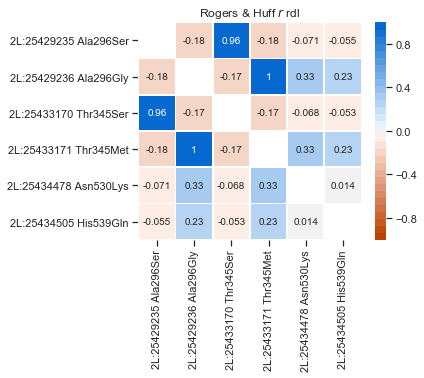

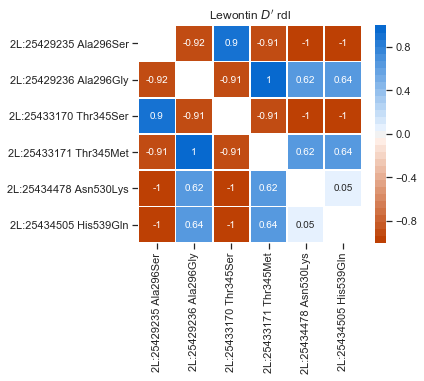

In [28]:
# plot minor allele freqs per pop
pdf = PdfPages("%s/%s_%s.allele_ld.pdf" % (outdir,outcode,l_nom))

# linkage disequilibrium Rogers and Huff
print("LD Rogers & Huff...")
fig = plt.figure(figsize=(5,4))
ld_rhr = allel.rogers_huff_r(oc_haploty_seg.compress(is_report).to_n_alt(fill=-1))
ld_rhr = squareform(ld_rhr)
np.fill_diagonal(ld_rhr,np.nan)
ax=sns.heatmap(ld_rhr,vmin=-1,vmax=1,cmap=sns.diverging_palette(20,255,s=99,sep=15,l=45,n=31),
               xticklabels=oc_snpname_seg[is_report],yticklabels=oc_snpname_seg[is_report],linewidths=0.8,linecolor="white",annot=True)
ax.set_title("Rogers & Huff $r$ %s" % l_nom)
pdf.savefig(fig,bbox_inches='tight')

# print table
ld_rhr_df = pd.DataFrame(ld_rhr)
ld_rhr_df.columns = oc_snpname_seg[is_report]
ld_rhr_df.rows    = oc_snpname_seg[is_report]
ld_rhr_df.to_csv("%s/%s_%s.allele_ld_rhr.csv" % (outdir,outcode,l_nom),sep="\t",index=False)

# lewontin D' linkage disequilibrium
print("LD Lewontin D'...")
fig = plt.figure(figsize=(5,4))
ld_lewdp = lewontin_d_prime_varloop(h=oc_haploty_seg.compress(is_report).to_n_alt(fill=-1))     
np.fill_diagonal(ld_lewdp,np.nan)
ax=sns.heatmap(ld_lewdp,vmin=-1,vmax=1,cmap=sns.diverging_palette(20,255,s=99,sep=15,l=45,n=31),
               xticklabels=oc_snpname_seg[is_report],yticklabels=oc_snpname_seg[is_report],linewidths=0.8,linecolor="white",annot=True)
ax.set_title("Lewontin $D'$ %s" % l_nom)
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

# print table
ld_lewdp_df = pd.DataFrame(ld_lewdp)
ld_lewdp_df.columns = oc_snpname_seg[is_report]
ld_lewdp_df.rows    = oc_snpname_seg[is_report]
ld_lewdp_df.to_csv("%s/%s_%s.allele_ld_lewdp.csv" % (outdir,outcode,l_nom),sep="\t",index=False)

Repeat, per population:

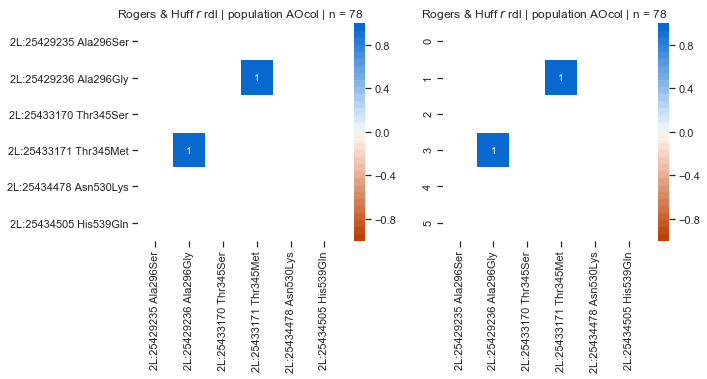

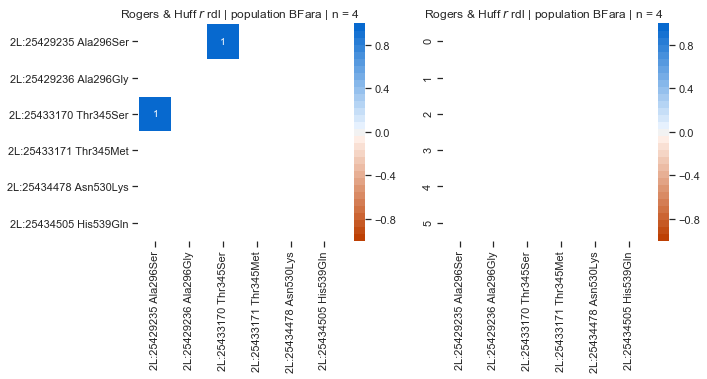

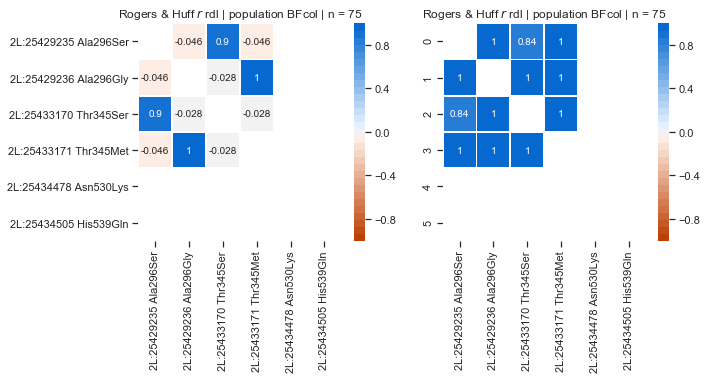

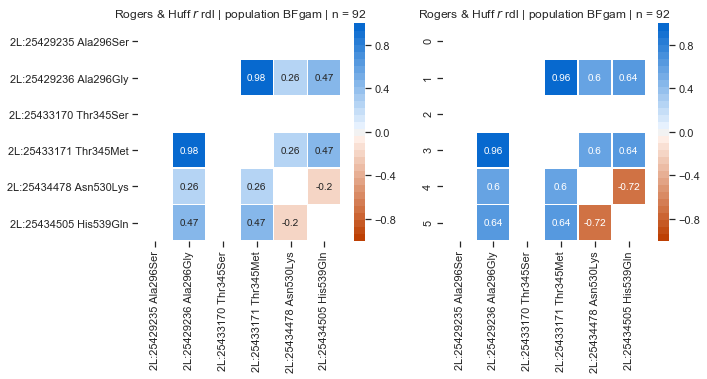

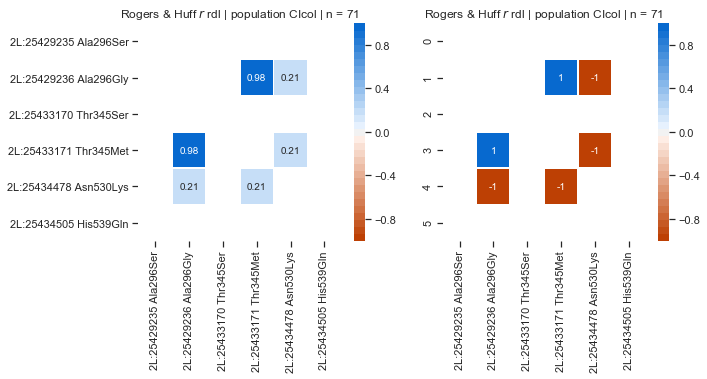

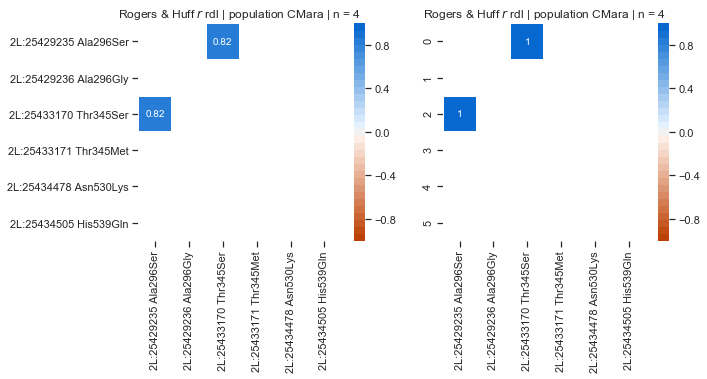

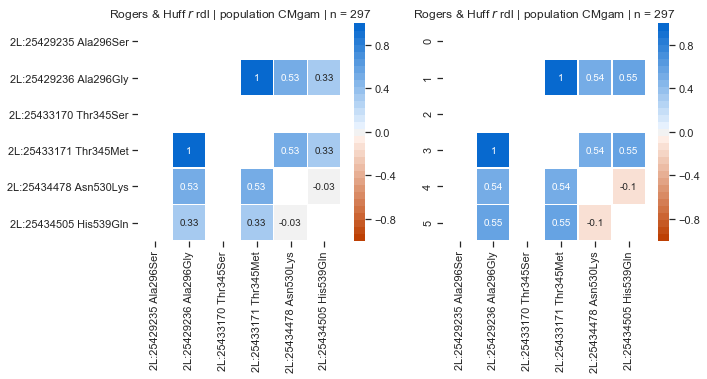

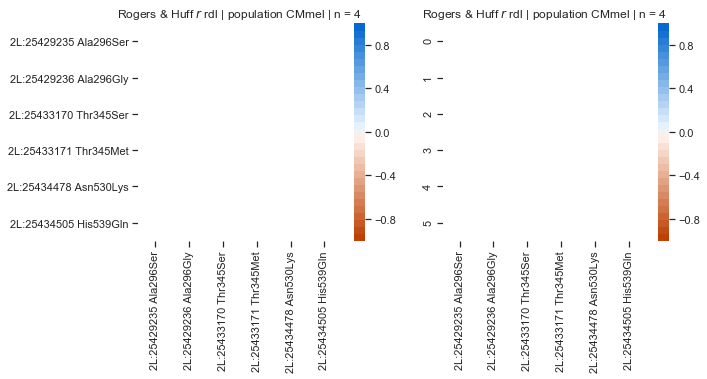

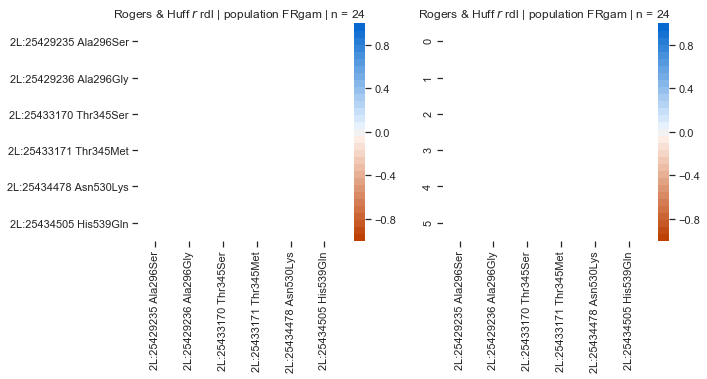

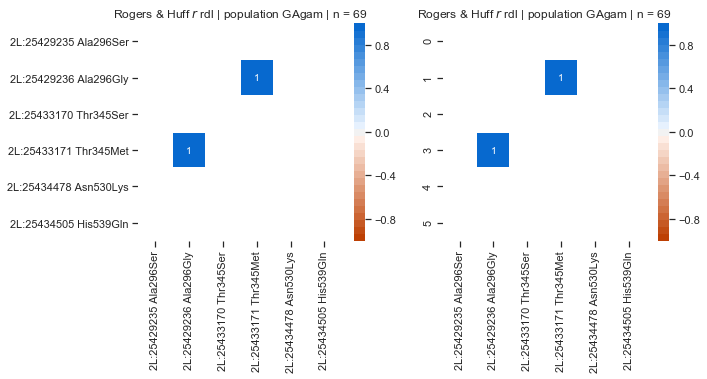

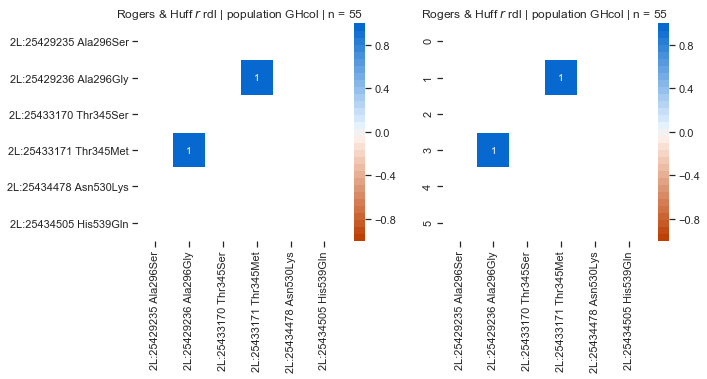

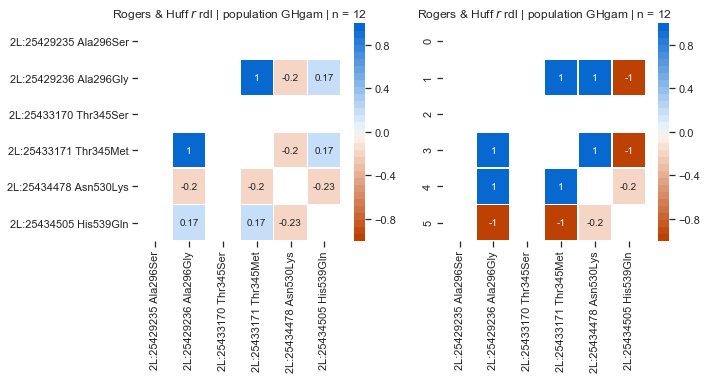

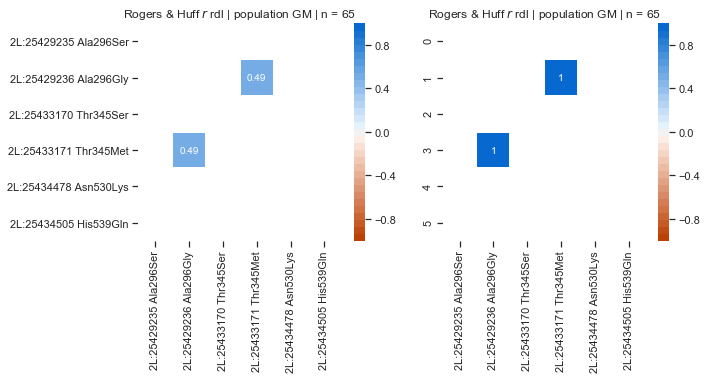

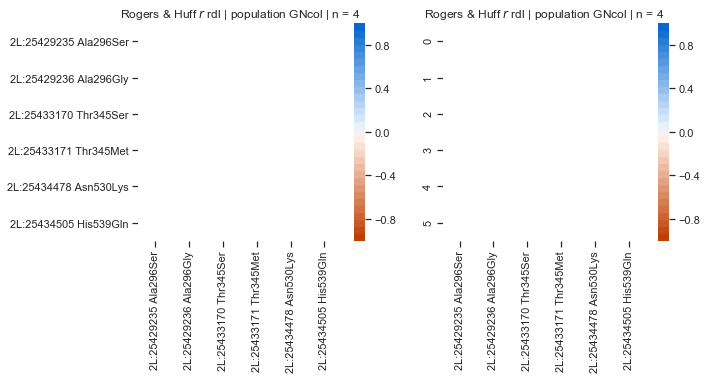

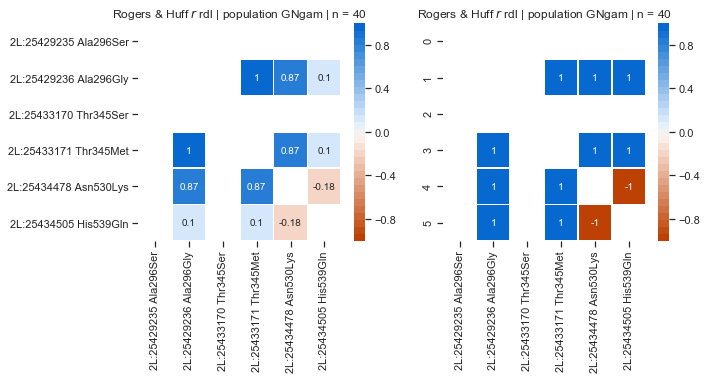

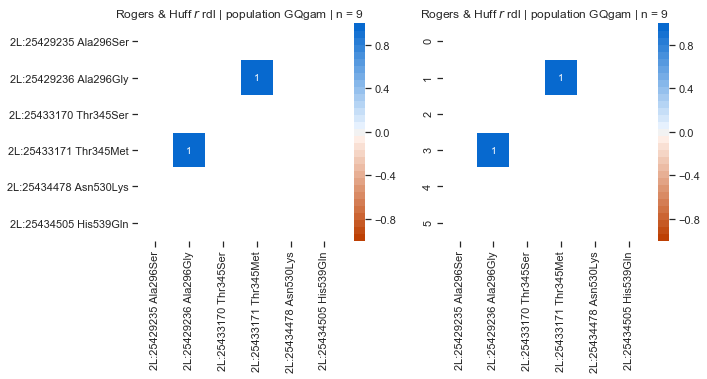

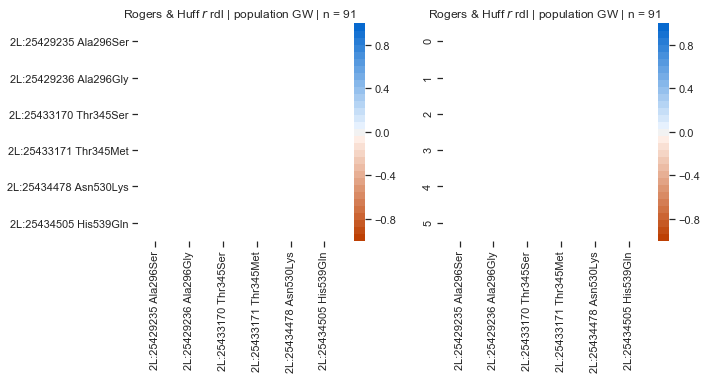

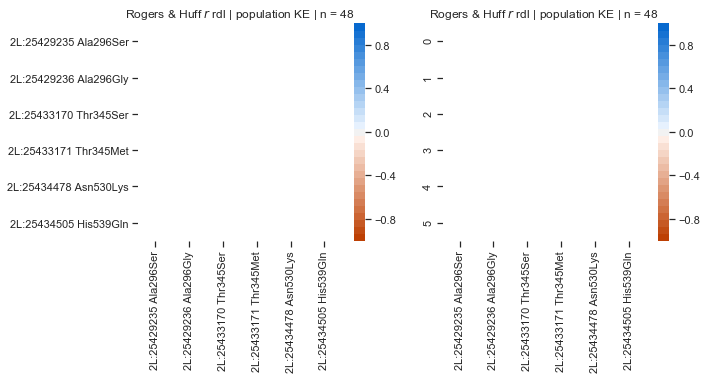

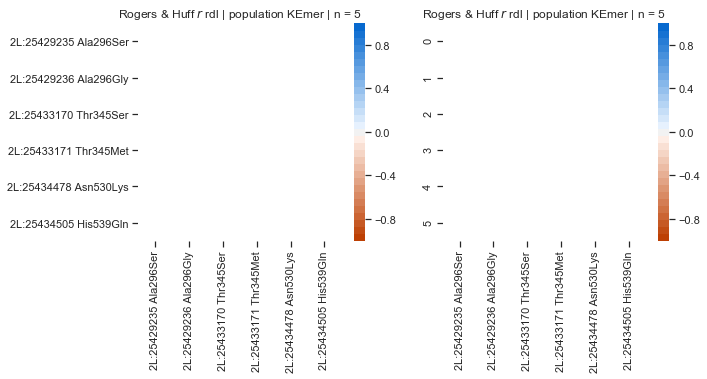

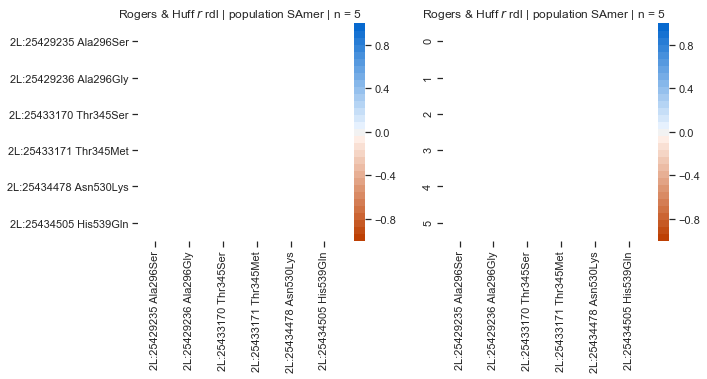

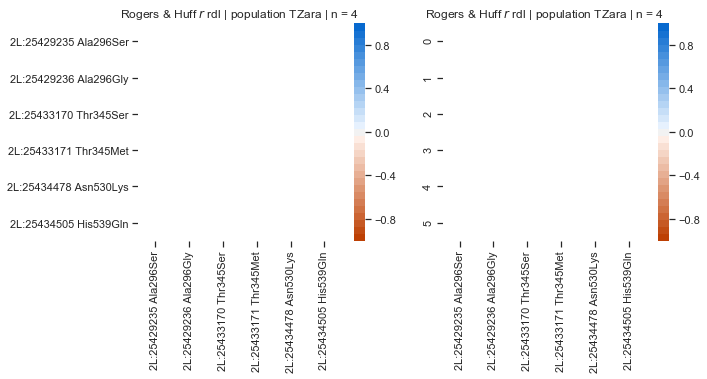

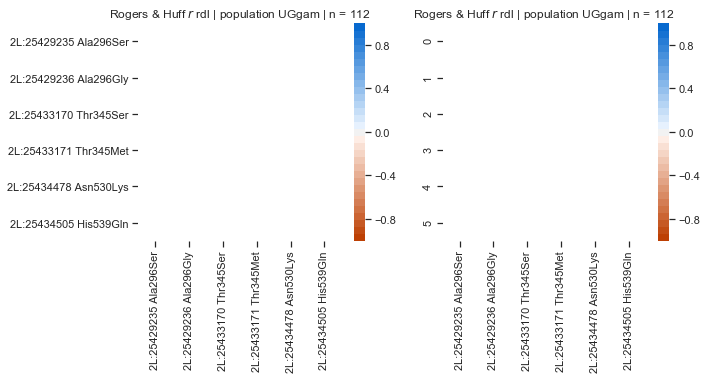

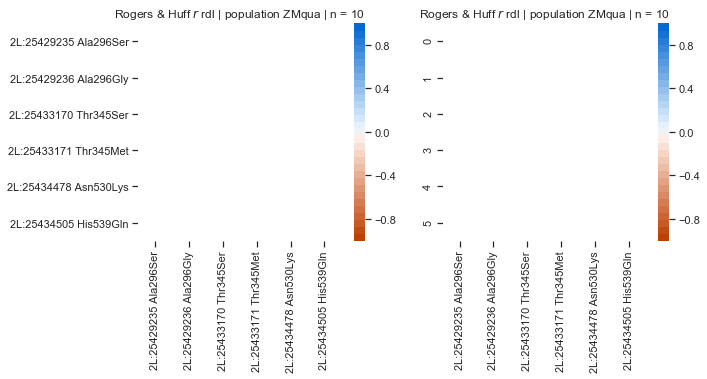

In [29]:
pdf = PdfPages("%s/%s_%s.allele_ld_perpop.pdf" % (outdir,outcode,l_nom))

for popi in oc_popl:
    
    h_popi = oc_haploty_seg.subset(sel0=is_report,sel1=oc_popdict[popi]).to_n_alt(fill=-1)[:]
    #h_popi[h_popi > 1] = 1
    
    # r
    fig = plt.figure(figsize=(10,4))
    ax1 = plt.subplot(1, 2, 1)
    ld_rhr_i = allel.rogers_huff_r(h_popi)
    ld_rhr_i = squareform(ld_rhr_i)
    np.fill_diagonal(ld_rhr_i,np.nan)
    ax=sns.heatmap(ld_rhr_i,vmin=-1,vmax=1,cmap=sns.diverging_palette(20,255,s=99,sep=15,l=45,n=31),
               xticklabels=oc_snpname_seg[is_report],yticklabels=oc_snpname_seg[is_report],linewidths=0.8,linecolor="white",annot=True)
    ax.set_title("Rogers & Huff $r$ %s | population %s | n = %i" % (l_nom,popi, h_popi.shape[1]))
    
    # D'
    ax1 = plt.subplot(1, 2, 2)
    ld_lewdp_i = lewontin_d_prime_varloop(h=h_popi)
    np.fill_diagonal(ld_lewdp_i,np.nan)
    ax=sns.heatmap(ld_lewdp_i,vmin=-1,vmax=1,cmap=sns.diverging_palette(20,255,s=99,sep=15,l=45,n=31),
               xticklabels=oc_snpname_seg[is_report],linewidths=0.8,linecolor="white",annot=True)
    ax.set_title("Rogers & Huff $r$ %s | population %s | n = %i" % (l_nom,popi, h_popi.shape[1]))
    pdf.savefig(fig,bbox_inches='tight')
    
pdf.close()

Repeat, but include all SNPs in Vgsc too:

In [30]:
is_in_vgsc     = np.logical_and(oc_hapvars_seg["POS"] >= 2358158, oc_hapvars_seg["POS"] <= 2431617)
is_coding_vgsc = np.asarray([oc_genveff_seg_ann[i].split("|")[1] == "missense_variant" for i,_ in enumerate(oc_genveff_seg_ann)])
is_report_vgsc = (is_in_vgsc & is_coding_vgsc & is_minfq)
is_report_vgsc_rdl = np.logical_or(is_report_vgsc, is_report)
sum(is_report_vgsc_rdl)

## ALTERNATIVE: only Rdl and 995FS alleles
# is_995FS            = np.logical_or(oc_hapvars_seg["POS"] == 2422651, oc_hapvars_seg["POS"] == 2422652)  # genotype of 995S or 995F
# is_report_with_vgsc = np.logical_or(is_995FS, is_report)
# sum(is_report_with_vgsc)

21

LD Rogers & Huff...
LD Lewontin D'...


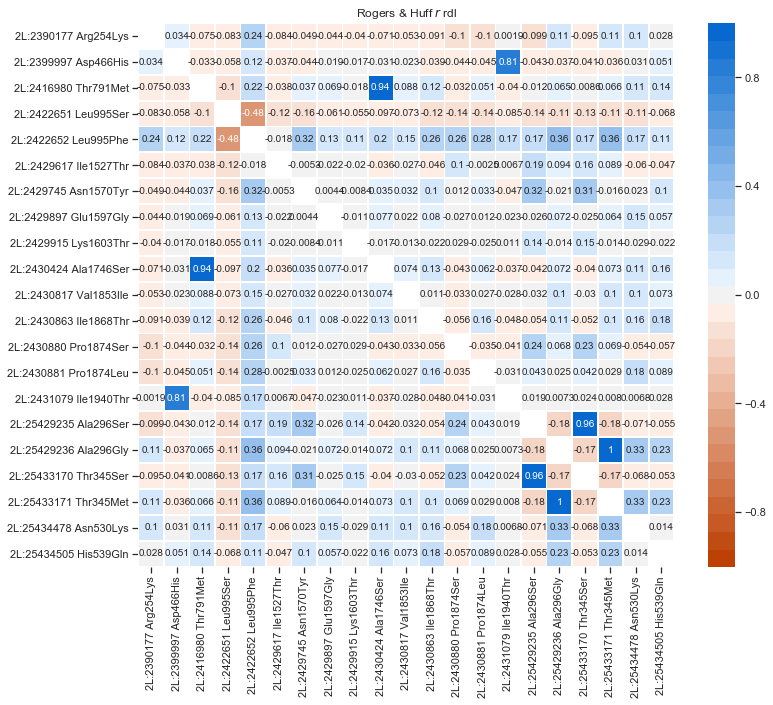

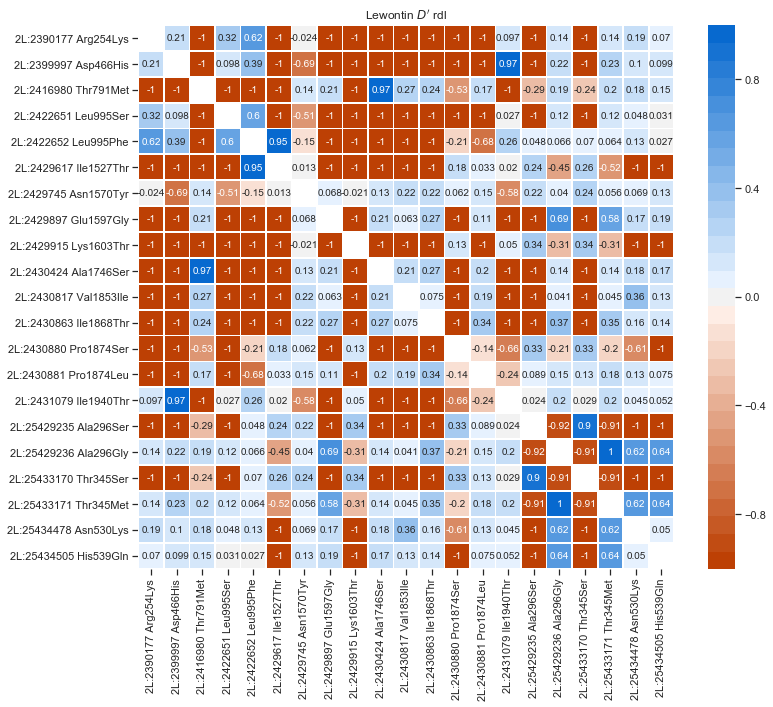

In [31]:
# plot minor allele freqs per pop
pdf = PdfPages("%s/%s_%s.allele_ld_vgsc.pdf" % (outdir,outcode,l_nom))

# linkage disequilibrium Rogers and Huff
print("LD Rogers & Huff...")
fig = plt.figure(figsize=(12,10))
ld_rhr = allel.rogers_huff_r(oc_haploty_seg.compress(is_report_vgsc_rdl).to_n_alt(fill=-1))
ld_rhr = squareform(ld_rhr)
np.fill_diagonal(ld_rhr,np.nan)
ax=sns.heatmap(ld_rhr,vmin=-1,vmax=1,cmap=sns.diverging_palette(20,255,s=99,sep=15,l=45,n=31),
               xticklabels=oc_snpname_seg[is_report_vgsc_rdl],yticklabels=oc_snpname_seg[is_report_vgsc_rdl],linewidths=0.8,linecolor="white",annot=True)
ax.set_title("Rogers & Huff $r$ %s" % l_nom)
pdf.savefig(fig,bbox_inches='tight')

# print table
ld_rhr_df = pd.DataFrame(ld_rhr)
ld_rhr_df.columns = oc_snpname_seg[is_report_vgsc_rdl]
ld_rhr_df.rows    = oc_snpname_seg[is_report_vgsc_rdl]
ld_rhr_df.to_csv("%s/%s_%s.allele_ld_rhr_vgsc.csv" % (outdir,outcode,l_nom),sep="\t",index=False)

# lewontin D' linkage disequilibrium
print("LD Lewontin D'...")
fig = plt.figure(figsize=(12,10))
ld_lewdp = lewontin_d_prime_varloop(h=oc_haploty_seg.compress(is_report_vgsc_rdl).to_n_alt(fill=-1))     
np.fill_diagonal(ld_lewdp,np.nan)
ax=sns.heatmap(ld_lewdp,vmin=-1,vmax=1,cmap=sns.diverging_palette(20,255,s=99,sep=15,l=45,n=31),
               xticklabels=oc_snpname_seg[is_report_vgsc_rdl],yticklabels=oc_snpname_seg[is_report_vgsc_rdl],linewidths=0.8,linecolor="white",annot=True)
ax.set_title("Lewontin $D'$ %s" % l_nom)
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

# print table
ld_lewdp_df = pd.DataFrame(ld_lewdp)
ld_lewdp_df.columns = oc_snpname_seg[is_report_vgsc_rdl]
ld_lewdp_df.rows    = oc_snpname_seg[is_report_vgsc_rdl]
ld_lewdp_df.to_csv("%s/%s_%s.allele_ld_lewdp_vgsc.csv" % (outdir,outcode,l_nom),sep="\t",index=False)

Linkage disequilibrium between all alleles (only $r$):

In [32]:
is_locifq = (is_in_loci & is_minfq)

# linkage disequilibrium Rogers and Huff
print("LD Rogers & Huff...")
ld_rhr_A = allel.rogers_huff_r(oc_haploty_seg.compress(is_locifq).to_n_alt(fill=-1))
ld_rhr_A = squareform(ld_rhr_A)
np.fill_diagonal(ld_rhr_A,np.nan)

# print table
ld_rhr_df = pd.DataFrame(ld_rhr_A)
ld_rhr_df.columns = oc_snpname_seg[is_locifq]
ld_rhr_df.rows    = oc_snpname_seg[is_locifq]
ld_rhr_df.to_csv("%s/%s_%s.allele_ld_rhr_all.csv" % (outdir,outcode,l_nom),sep="\t",index=False)

print("Housekeeping...")
del ld_rhr_A

LD Rogers & Huff...
Housekeeping...


## Haplotype networks

Visualize haplotype similarity with **haplotype networks**, built from phased variants around the *Rdl* gene.

We focus on the variants located around the 296th codon, +- 10kbp (`fbp_hap` variable) (i.e. core haplotype).

In [33]:
# input hap networks
loc_vari = 25429236  # variable to use as focus of hap networks -> position in the genome
loc_varn = "A296G"   # name it

# parameters hap networks
fbp_hap  = 1e4     # num bp to retain around variant of interest (allele) to define core haplotyes, CC uses 6kbp
max_dist = 3       # dist that breaks edges; default is 5; CC uses 2 -> if network method is MJN, then it doesn't work for max_dist>1!!!!
max_alle = 1       # indirect variant breaks
net_meth = "msn"   # can be: minimum_spanning_network msn ; minimum_spanning_tree mst ; median_joining_network mjt
min_fq_h = 0.01    # min freq of the haplotype cluster, below that the component will be excluded from plots
min_fc_h = int(min_fq_h*oc_haploty_hap_seg.shape[1])

loc_vari_bool = np.any(oc_hapvars["POS"]   == loc_vari)
loc_vari_ix   = np.where(oc_hapvars["POS"] == loc_vari)[0][0]

# report
print("Is %i %s in phased array? %s: index %i " % (loc_vari,loc_varn,loc_vari_bool,loc_vari_ix))

Is 25429236 A296G in phased array? True: index 3403238 


Subset haplotypes to focus on variants around focal locus:

In [34]:
# subset hap arrays to fit loci of interest (loci centre +/- fbp_hap)
loc_pos_ix = allel.SortedIndex(oc_hapvars_seg['POS'])
loc_pos_rn = loc_pos_ix.locate_range(loc_vari-fbp_hap,loc_vari+fbp_hap)

# snp name
oc_snpname_seg_mis = oc_snpname_seg_cod
oc_snpname_seg_mis[np.invert(is_coding)] = ""
loc_hap    = oc_haploty_hap_seg[loc_pos_rn]
loc_snpnom = oc_snpname_seg_mis[loc_pos_rn]

# report
print("Phased variants and samples around %s:" % loc_vari,loc_hap.shape)

# color arrays
loc_colpop = np.array([pop_colors[p] for p in oc_sampleh["population"].values])
loc_colpos = np.array([pos_colors[p] for p in oc_sampleh["population"].values])
loc_gty_A  = oc_haploty_hap_seg[ np.where(loc_pos_ix==loc_vari)[0][0] ]       # genotype of A296G
loc_gty_B  = oc_haploty_hap_seg[ np.where(loc_pos_ix==25429235)[0][0] ] * 2   # genotype of A296S
loc_gty_T  = loc_gty_A+loc_gty_B
loc_colvar = np.array([var_colors[p] for p in loc_gty_T])

Phased variants and samples around 25429236: (626, 2356)


Build **hap networks colored by population**, and store which samples are in which component:

In [35]:
loc_graph, loc_distinct_sets, loc_components = graph_haplotype_network(
    h=loc_hap,
    max_dist=max_dist,   
    max_allele=max_alle, # for MJN only; default is 3
    show_node_labels=min_fc_h,
    distance_metric='hamming',network_method=net_meth,
    hap_colors=loc_colpop,variant_labels=loc_snpnom,
    return_components=True,show_singletons=False)

num_components = loc_components.shape[0]

# plot pdf
loc_graph.format = 'pdf'
loc_graph.attr(label='\n\n%s %s %s:%i\n%i haps clustered into %i clusters with %s maxdist %i, from %i phased vars located +/- %i bp' % (l_nom,loc_varn,chrom,loc_vari,loc_hap.shape[1],num_components,net_meth,max_dist,loc_hap.shape[0],fbp_hap))
fn = "%s/%s_%s.hn_%s_var_%s_%s-pop" % (outdir,outcode,l_nom,net_meth,loc_vari,loc_varn)
loc_graph.render(fn,cleanup=True)

'haplotype_analysis_output/rdo_hapnet_rdl.hn_msn_var_25429236_A296G-pop.pdf'

In [36]:
# map hap clusters with REF alleles to actual lists of populations
# BEWARE: identify_components fails if max_dist > 1 in MJN
def identify_components(h_distinct_sets, components):
    """This function is designed to collect all indices for original haplotypes 
    within each connected component. I.e., it finds clusters from the network."""
    clusters = []
    for c in np.unique(components):
        cluster = set()
        for i in np.nonzero(components == c)[0]:
            cluster |= h_distinct_sets[i]
        clusters.append(sorted(cluster))
    return clusters

loc_components_id      = identify_components(loc_distinct_sets, loc_components) 
loc_components_id_hapi = []
loc_components_id_clui = []
loc_components_id_dati = pd.DataFrame()
for n,i in enumerate(loc_components_id):
    loc_components_id_hapi = loc_components_id_hapi + loc_components_id[n]
    loc_components_id_clui = loc_components_id_clui + list([n]*len(loc_components_id[n]))

loc_components_id_dati["hap_index"]   = loc_components_id_hapi
loc_components_id_dati["hap_cluster"] = loc_components_id_clui
loc_components_id_dati                = loc_components_id_dati.sort_values(by="hap_index")
loc_components_id_dati                = loc_components_id_dati.set_index(keys="hap_index")
loc_components_id_dati["pop"]         = oc_sampleh["population"].values
loc_components_id_dati["hap_id"]      = oc_sampleh["ox_code"].values

# report
print("total haps:",loc_hap.shape[1])
print("num haps per cluster (only clusters n>=%i):" % min_fc_h)
print(loc_components_id_dati.groupby(("hap_cluster")).size()[loc_components_id_dati.groupby(("hap_cluster")).size()>=min_fc_h])

total haps: 2356
num haps per cluster (only clusters n>=23):
hap_cluster
4      651
34      94
342     31
505     28
507     46
763     30
dtype: int64


In [37]:
loc_components_id_dati["Rdl_296"] = loc_gty_T

Which clusters should we print? Those with frequency > 1% in the cohort (`min_fc_h` and `min_fq_h` variables, defined above):

In [38]:
min_cluster_size = min_fc_h
    
# select clusters
clu_list_ids     = np.unique(loc_components_id_dati["hap_cluster"],return_counts=True)[0]
clu_list_cou     = np.unique(loc_components_id_dati["hap_cluster"],return_counts=True)[1]
clu_list_ids_fil = clu_list_ids[clu_list_cou >= min_cluster_size]
clu_list_cou_fil = clu_list_cou[clu_list_cou >= min_cluster_size]
loc_printhap     = np.isin(loc_components_id_dati["hap_cluster"].values, clu_list_ids_fil)

print(loc_varn,loc_vari,"print clusters:",clu_list_ids_fil,"\t\tsize of clusters: ",clu_list_cou_fil)
print(loc_varn,loc_vari,"print clusters total size:",sum(loc_printhap),"/",len(loc_printhap))

A296G 25429236 print clusters: [  4  34 342 505 507 763] 		size of clusters:  [651  94  31  28  46  30]
A296G 25429236 print clusters total size: 880 / 2356


In [39]:
loc_graph, loc_distinct_sets, loc_components = graph_haplotype_network(
    h=loc_hap.subset(sel1=loc_printhap),
    max_dist=max_dist,   
    max_allele=max_alle, # for MJN only; default is 3
    show_node_labels=100,
    distance_metric='hamming',network_method=net_meth,
    hap_colors=loc_colpop[loc_printhap],variant_labels=loc_snpnom,
    return_components=True,show_singletons=False)

num_components = loc_components.shape[0]

# plot pdf
loc_graph.format = 'pdf'
loc_graph.attr(label='\n\n%s %s %s:%i\n%i haps clustered into %i clusters with %s maxdist %i, from %i phased vars located +/- %i bp' % (l_nom,loc_varn,chrom,loc_vari,loc_hap.shape[1],num_components,net_meth,max_dist,loc_hap.shape[0],fbp_hap))
fn = "%s/%s_%s.hn_%s_var_%s_%s-pop_minfq" % (outdir,outcode,l_nom,net_meth,loc_vari,loc_varn)
loc_graph.render(fn,cleanup=True)

'haplotype_analysis_output/rdo_hapnet_rdl.hn_msn_var_25429236_A296G-pop_minfq.pdf'

Plot hap networks colored by species:

* col is red
* gam is green
* gamcol hybrids are blue
* arabiensis is orange
* quadriannulatus is gray
* merus is slategray
* melas is steelish-blue

In [40]:
loc_graph, loc_distinct_sets, loc_components = graph_haplotype_network(
    h=loc_hap.subset(sel1=loc_printhap),
    max_dist=max_dist,   
    max_allele=max_alle, # for MJN only; default is 3
    show_node_labels=100,
    distance_metric='hamming',network_method=net_meth,
    hap_colors=loc_colpos[loc_printhap],variant_labels=loc_snpnom,
    return_components=True,show_singletons=False)

num_components = loc_components.shape[0]

# plot pdf
loc_graph.format = 'pdf'
loc_graph.attr(label='\n\n%s %s %s:%i\n%i haps clustered into %i clusters with %s maxdist %i, from %i phased vars located +/- %i bp' % (l_nom,loc_varn,chrom,loc_vari,loc_hap.shape[1],num_components,net_meth,max_dist,loc_hap.shape[0],fbp_hap))
fn = "%s/%s_%s.hn_%s_var_%s_%s-sps_minfq" % (outdir,outcode,l_nom,net_meth,loc_vari,loc_varn)
loc_graph.render(fn,cleanup=True)

'haplotype_analysis_output/rdo_hapnet_rdl.hn_msn_var_25429236_A296G-sps_minfq.pdf'

Plot haplotype networks colored by genotype in the 296th codon:

* wt is gray (0)
* 296G is light blue (1)
* 296S is dark blue (2)
* 296S+296G is violet (3)
* missing genotype is orange (-1)

In [41]:
loc_graph, loc_distinct_sets, loc_components = graph_haplotype_network(
    h=loc_hap.subset(sel1=loc_printhap),
    max_dist=max_dist,   
    max_allele=max_alle, # for MJN only; default is 3
    show_node_labels=100,
    distance_metric='hamming',network_method=net_meth,
    hap_colors=loc_colvar[loc_printhap],variant_labels=loc_snpnom,
    return_components=True,show_singletons=False)

num_components = loc_components.shape[0]

# plot pdf
loc_graph.format = 'pdf'
loc_graph.attr(label='\n\n%s %s %s:%i\n%i haps clustered into %i clusters with %s maxdist %i, from %i phased vars located +/- %i bp' % (l_nom,loc_varn,chrom,loc_vari,loc_hap.shape[1],num_components,net_meth,max_dist,loc_hap.shape[0],fbp_hap))
fn = "%s/%s_%s.hn_%s_var_%s_%s-gty_minfq" % (outdir,outcode,l_nom,net_meth,loc_vari,loc_varn)
loc_graph.render(fn,cleanup=True)

'haplotype_analysis_output/rdo_hapnet_rdl.hn_msn_var_25429236_A296G-gty_minfq.pdf'

Add genotypes for 345th codon:

* wt is 0
* 995S is 1
* 995F is 2

In [42]:
loc_gty_A  = oc_haploty_hap_seg[ np.where(loc_pos_ix==25433170)[0][0] ] * 2   # genotype of 345S
loc_gty_B  = oc_haploty_hap_seg[ np.where(loc_pos_ix==25433171)[0][0] ]       # genotype of 345M
loc_gty_T  = loc_gty_A+loc_gty_B
loc_components_id_dati["Rdl_345"] = loc_gty_T

Plot haplotype networks colored by genotype in Vgsc 995th codon:

* wt is gray (0)
* 995S is light blue (1)
* 995F is dark blue (2)
* 995S+995F is violet (3)
* missing genotype is orange (-1)

In [43]:
loc_gty_A  = oc_haploty_hap_seg[ np.where(loc_pos_ix==2422651)[0][0] ]       # genotype of 995S
loc_gty_B  = oc_haploty_hap_seg[ np.where(loc_pos_ix==2422652)[0][0] ] * 2   # genotype of 995F
loc_gty_T  = loc_gty_A+loc_gty_B
loc_components_id_dati["Vgsc_995"] = loc_gty_T
loc_colvar = np.array([var_colors[p] for p in loc_gty_T])

In [44]:
loc_graph, loc_distinct_sets, loc_components = graph_haplotype_network(
    h=loc_hap.subset(sel1=loc_printhap),
    max_dist=max_dist,   
    max_allele=max_alle, # for MJN only; default is 3
    show_node_labels=100,
    distance_metric='hamming',network_method=net_meth,
    hap_colors=loc_colvar[loc_printhap],variant_labels=loc_snpnom,
    return_components=True,show_singletons=False)

num_components = loc_components.shape[0]

# plot pdf
loc_graph.format = 'pdf'
loc_graph.attr(label='\n\n%s %s %s:%i\n%i haps clustered into %i clusters with %s maxdist %i, from %i phased vars located +/- %i bp' % (l_nom,loc_varn,chrom,loc_vari,loc_hap.shape[1],num_components,net_meth,max_dist,loc_hap.shape[0],fbp_hap))
fn = "%s/%s_%s.hn_%s_var_%s_%s-gtyvgsc_minfq" % (outdir,outcode,l_nom,net_meth,loc_vari,loc_varn)
loc_graph.render(fn,cleanup=True)

'haplotype_analysis_output/rdo_hapnet_rdl.hn_msn_var_25429236_A296G-gtyvgsc_minfq.pdf'

Legend for population colors:

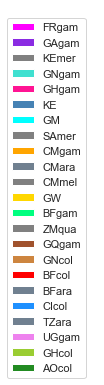

In [45]:
# plot color legend
# WARNING: colors might be slightly different because matplotlib and graphviz parse them differently
pdf = PdfPages("%s/%s_%s.hn_legend.pdf" % (outdir,outcode,l_nom))
fig,ax = plt.subplots(figsize=(1,1))
ax.set_axis_off()
custom_lines = [mpatches.Patch(facecolor=pop_colors[coli]) for coli in pop_colors.keys()]
plt.legend(labels=pop_colors.keys(),handles=custom_lines)
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

Now, output table with clusters, for posterity:

In [46]:
loc_components_id_dati.to_csv("%s/%s_%s.hn_result.csv" % (outdir,outcode,l_nom),sep="\t",index=False)

If you examine this table and the haplotype networks, you'll see that:

* 296G genotypes are clustered in the component `4`, with 651 specimens from many different populations of gam and col
* 296S genotypes are clustered in component `34`, with 94 specimens from BFcol
* wt genotypes are grouped in many other components

These component codes are important for downstream analyses (pop distribution, positive selection analyses, etc.).

### Distribution of populations per haplotype

Barplots:

In [47]:
def annotate_barplot(ax,color="k", labformat = "{:.2f}"):
    rects = ax.patches
    for rect in rects:
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2
        space   = 5
        ha      = 'left'
        label   = labformat.format(x_value) ## annotates bars with height labels, with 2 decimal points
        plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", va='center', ha=ha, color=color)


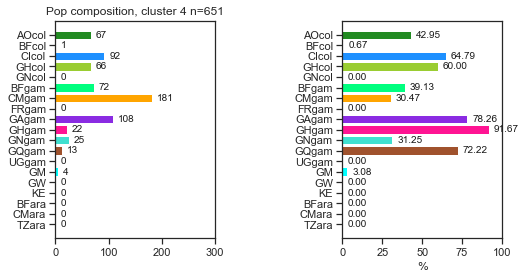

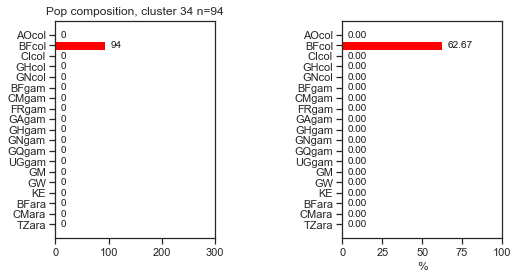

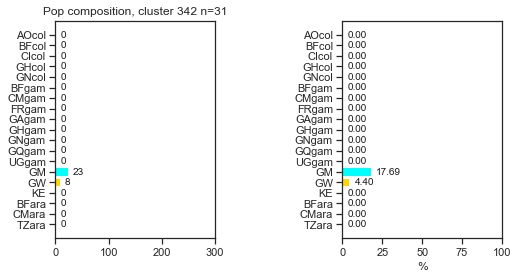

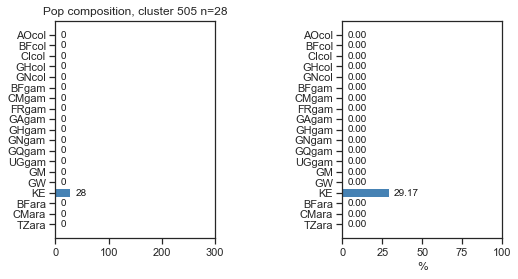

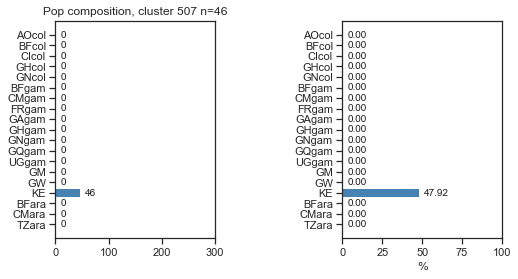

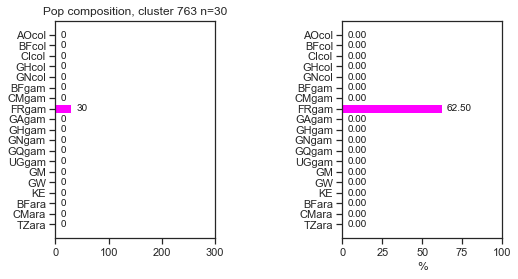

In [48]:
pdf = PdfPages("%s/%s_%s.hn_popcomp_perhap.pdf" % (outdir,outcode,l_nom))

for i,clui in enumerate(clu_list_ids_fil):

    fig = plt.figure(figsize=(8,4))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=None)
    
    # and now: some barplots with pop composition of each cluster
    ax1 = plt.subplot(1, 2, 1)
    hap_labl = "Pop composition, cluster "+str(clui)+" n="+str(clu_list_cou_fil[i])
    hap_clui = loc_components_id_dati["hap_id"][loc_components_id_dati["hap_cluster"] == int(clui)]
    hap_popi = loc_components_id_dati["pop"][loc_components_id_dati["hap_cluster"] == int(clui)]
    pie_labels = ["AOcol","BFcol","CIcol","GHcol","GNcol","BFgam","CMgam","FRgam","GAgam","GHgam","GNgam","GQgam","UGgam","GM","GW","KE","BFara","CMara","TZara"]
    pie_counts = [len(np.where(hap_popi==popi)[0]) for popi in pie_labels]
    pie_colors = [pop_colors[popi] for popi in pie_labels]
    plt.barh(width=pie_counts[::-1],y=pie_labels[::-1],color=pie_colors[::-1])
    ax1.set_xlim(0,300)
    annotate_barplot(ax=ax1, labformat="{:.0f}")
    plt.title(hap_labl)

    # and next: some barplots with pop % of each cluster
    ax2 = plt.subplot(1, 2, 2)
    hap_labl = "% of haps from each pop in cluster"
    pie_coutot = oc_sampleh.groupby("population").size()
    pie_coutot = pie_coutot[pie_labels]
    pie_fracti = pie_counts / pie_coutot * 100
    plt.barh(width=pie_fracti[::-1],y=pie_labels[::-1],color=pie_colors[::-1])
    annotate_barplot(ax=ax2, labformat="{:.2f}")
    ax2.set_xlabel("%")
    ax2.set_xlim(0,100)

    pdf.savefig(fig,bbox_inches='tight')
    
pdf.close()

Pie plots of main haplotypes per population:

* `4` is 296G
* `34` is 296S
* some wt are with frequency >1% have their own code and color scheme
* `other` are all other wt, with low frequency (<1%)

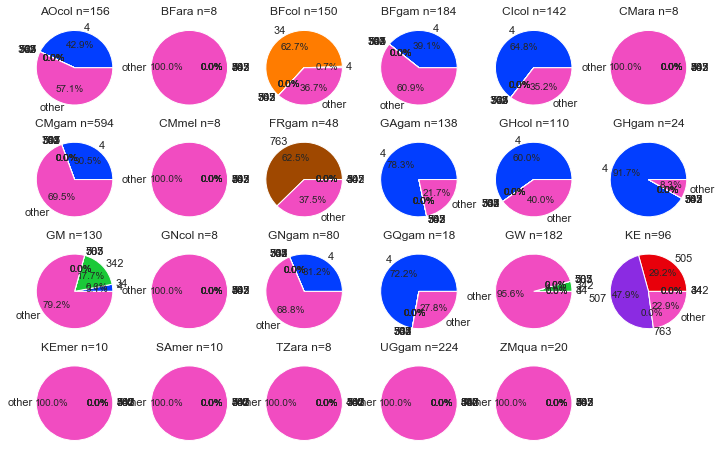

In [49]:
pdf = PdfPages("%s/%s_%s.hn_popcomp_perpop.pdf" % (outdir,outcode,l_nom))
fig = plt.figure(figsize=(12,12))

for popi_n,popi in enumerate(oc_popl):
    
    ax2 = plt.subplot(6, 6, popi_n+1)

    hap_popi = loc_components_id_dati["hap_cluster"][loc_components_id_dati["pop"] == popi]
    pie_coun = [sum(hap_popi == i) for i in clu_list_ids_fil]
    pie_coub = np.append(pie_coun, len(hap_popi)-sum(pie_coun))
    pie_labb = np.append(clu_list_ids_fil, "other")
    pie_titl = popi+" n="+str(len(hap_popi))
    ax2.pie(pie_coub,labels=pie_labb, autopct="%1.1f%%")
    plt.title(pie_titl)

pdf.savefig(fig,bbox_inches='tight')
pdf.close()

pdf = PdfPages("%s/%s_%s.hn_popcomp_perpop.pdf" % (outdir,outcode,l_nom))

for popi in oc_popl:
    
    fig = plt.figure(figsize=(2,2))
    
    ax2 = plt.subplot(1, 1, 1)

    hap_popi = loc_components_id_dati["hap_cluster"][loc_components_id_dati["pop"] == popi]
    pie_coun = [sum(hap_popi == i) for i in clu_list_ids_fil]
    pie_coub = np.append(pie_coun, len(hap_popi)-sum(pie_coun))
    pie_labb = np.append(clu_list_ids_fil, "other")
    pie_titl = "Pop composition "+popi+" n="+str(len(hap_popi))
    ax2.pie(pie_coub,labels=pie_labb, autopct="%1.1f%%")
    plt.title(pie_titl)
    pdf.savefig(fig,bbox_inches='tight')
    
pdf.close()

## Selection signals in clusters

We want to see if the resistance haplotypes defined above have positive selection. 

In this analysis, we include clusters those with resistance alleles (cluster 4 is 296G, cluster 34 is 296S):

In [50]:
min_cluster_size = 50
    
# select clusters
clu_list_ids     = np.unique(loc_components_id_dati["hap_cluster"],return_counts=True)[0]
clu_list_cou     = np.unique(loc_components_id_dati["hap_cluster"],return_counts=True)[1]
clu_list_ids_fil = clu_list_ids[clu_list_cou >= min_cluster_size]
clu_list_cou_fil = clu_list_cou[clu_list_cou >= min_cluster_size]

print(loc_varn,loc_vari,"print EHH for clusters:",clu_list_ids_fil,"\t\tsize of clusters: ",clu_list_cou_fil)

A296G 25429236 print EHH for clusters: [ 4 34] 		size of clusters:  [651  94]


Create dictionary of associations haplotype-cluster:

In [51]:
# create hap dictionary: similar to pop dict, but for associations hap-cluster
popdich_clu = dict()
# populate dict of interest
for clui in clu_list_ids_fil: 
    clu_key = "cluster_"+str(clui)
    popdich_clu[clu_key] = [oc_sampleh["ox_code"].values.tolist().index(i) for i in loc_components_id_dati["hap_id"].values[loc_components_id_dati["hap_cluster"]==clui]]
# populate dict with all other samples
popdich_clu["cluster_no"] = []
for clui in clu_list_ids[clu_list_cou < min_cluster_size]: 
    popdich_clu["cluster_no"] = popdich_clu["cluster_no"] + [oc_sampleh["ox_code"].values.tolist().index(i) for i in loc_components_id_dati["hap_id"].values[loc_components_id_dati["hap_cluster"]==clui]]

oc_hapalco_hap_clu_seg = oc_haploty_hap_seg.count_alleles_subpops(subpops=popdich_clu)
oc_hapalco_hap_clu_seg.shape

(4631559,)

### EHH decay

Now calculate **EHH decay** on the region of interest, using phased variants around it (+/- a certain number of bases):

EHH cluster_4
EHH cluster_34
EHH cluster_no


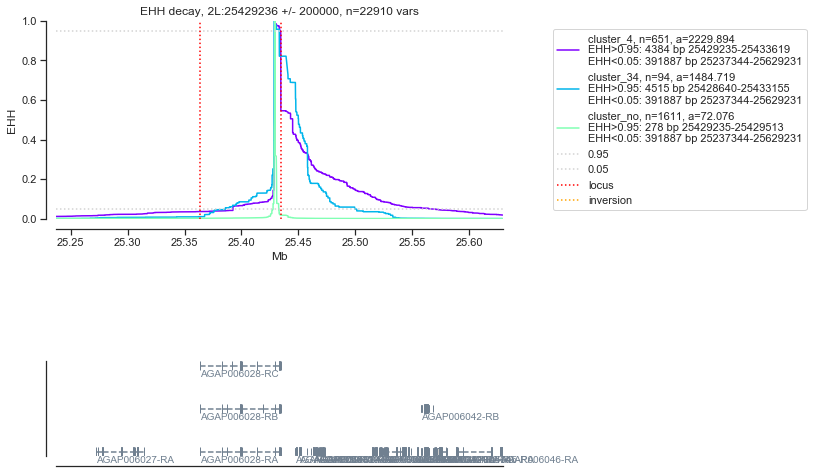

In [52]:
colors        = cm.rainbow(np.linspace(0, 1, len(clu_list_ids_fil)+3))
ehh_above_thr = 0.95
ehh_below_thr = 0.05
flank_bp_EHH  = 200000

# variants to retain
clu_varbool_up = np.logical_and(oc_hapvars_seg["POS"] >= loc_vari-flank_bp_EHH, oc_hapvars_seg["POS"] < loc_vari)
clu_varbool_do = np.logical_and(oc_hapvars_seg["POS"] > loc_vari, oc_hapvars_seg["POS"] <= loc_vari+flank_bp_EHH)
clu_varbool    = np.logical_or(clu_varbool_up,clu_varbool_do)

# samples to remove from analysis (EHH function can't handle missing -1 data)
rmv_miss_ix   = np.unique(np.where(oc_haploty_hap_seg.subset(sel0=clu_varbool) == -1)[1]).tolist()
rmv_miss_bool = np.invert(np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=rmv_miss_ix))

# positions
clu_ehh_pos = oc_hapvars_seg["POS"].subset(sel0=clu_varbool)

# plot
pdf = PdfPages("%s/%s_%s.sel_EHHdecay.pdf" % (outdir,outcode,l_nom))
fig = plt.figure(figsize=(8,8))
ax3 = plt.subplot(2, 1, 1)

for i,clui in enumerate(np.append(clu_list_ids_fil,"no")):

    clu_key = "cluster_"+str(clui)
    print("EHH %s" % clu_key)

    # which variants include in the cluster-wise analysis of selection?
    clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=popdich_clu[clu_key])
    clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)
    
    # calculate actual EHH
    clu_ehh_up_i = allel.ehh_decay(h=oc_haploty_hap_seg.subset(sel0=clu_varbool_up,sel1=clu_sambool))
    clu_ehh_do_i = allel.ehh_decay(h=oc_haploty_hap_seg.subset(sel0=clu_varbool_do,sel1=clu_sambool))
    clu_ehh_i    = np.concatenate((clu_ehh_up_i[::-1],clu_ehh_do_i))
    clu_ehh_i_ar = np.trapz(clu_ehh_i)
    ehh_above_start = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[0]
    ehh_above_end   = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[-1]
    ehh_below_start = clu_ehh_pos.compress(clu_ehh_i < ehh_below_thr)[0]
    ehh_below_end   = clu_ehh_pos.compress(clu_ehh_i < ehh_below_thr)[-1]

    # lab is data
    clu_lab    = "%s, n=%i, a=%.3f\nEHH>%.2f: %i bp %i-%i\nEHH<%.2f: %i bp %i-%i" % (
        clu_key, len(popdich_clu[clu_key]),clu_ehh_i_ar, 
        ehh_above_thr, ehh_above_end-ehh_above_start, ehh_above_start, ehh_above_end,
        ehh_below_thr, ehh_below_end-ehh_below_start, ehh_below_start, ehh_below_end
    )
    
    # plot EHH background & foreground
    ax3.plot(clu_ehh_pos/1e6,clu_ehh_i,color=colors[i],label=clu_lab,mfc='none')

sns.despine(ax=ax3,offset=10)
ax3.set_title("EHH decay, %s:%i +/- %i, n=%s vars" % (chrom,loc_vari,flank_bp_EHH,clu_ehh_pos.shape[0]))
ax3.set_xlabel("Mb")
ax3.set_ylabel("EHH")
ax3.set_xlim(clu_ehh_pos[0]/1e6,clu_ehh_pos[-1]/1e6)
ax3.set_ylim(0,1)
plt.axhline(ehh_above_thr, color='lightgray',linestyle=":",label=str(ehh_above_thr))
plt.axhline(ehh_below_thr, color='lightgray',linestyle=":",label=str(ehh_below_thr))
plt.axvline(loc_start/1e6, color='red',linestyle=":",label="locus")
plt.axvline(loc_end/1e6, color='red',linestyle=":",label="")
plt.axvline(inv_start/1e6, color='orange',linestyle=":",label="inversion")
plt.axvline(inv_end/1e6, color='orange',linestyle=":",label="")
ax3.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# plot transcripts
ax4 = plt.subplot(4, 1, 4)
sns.despine(ax=ax4,offset=10)
ax4.axes.get_xaxis().set_ticks([])
ax4.axes.get_xlabel() == ""
locus_genel = plot_transcripts(
    geneset=geneset,chrom=chrom,
    start=clu_ehh_pos[0],stop=clu_ehh_pos[-1],
    height=0.2,label_transcripts=True,ax=ax4,label_axis=False,
    color="slategray")

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

Same, with higher resolution to be able to see exons in *Rdl*:

EHH cluster_4
EHH cluster_34
EHH cluster_no


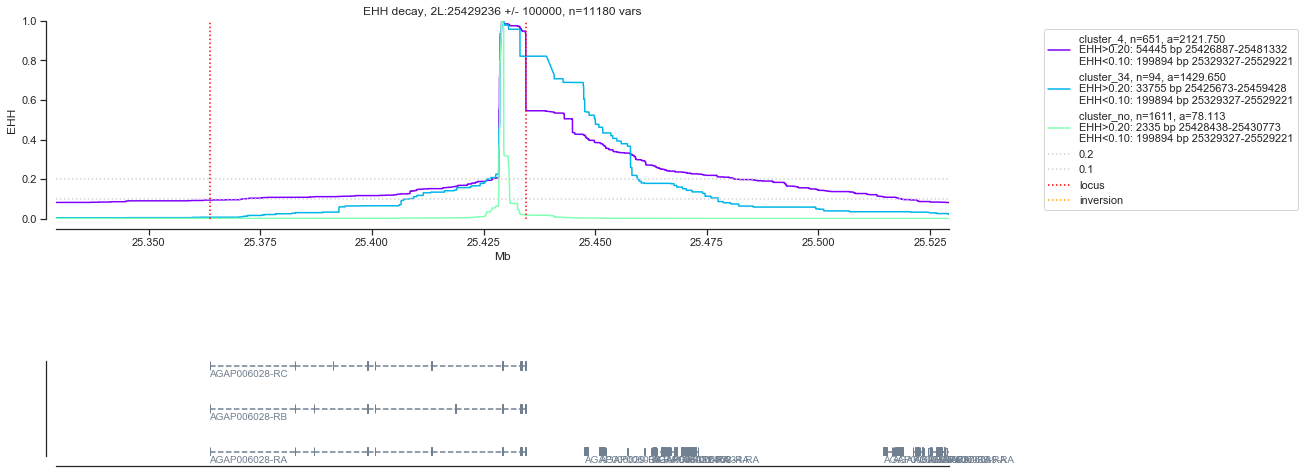

In [53]:
colors        = cm.rainbow(np.linspace(0, 1, len(clu_list_ids_fil)+3))
ehh_above_thr = 0.2
ehh_below_thr = 0.1
flank_bp_EHH  = 100000

# variants to retain
clu_varbool_up = np.logical_and(oc_hapvars_seg["POS"] >= loc_vari-flank_bp_EHH, oc_hapvars_seg["POS"] < loc_vari)
clu_varbool_do = np.logical_and(oc_hapvars_seg["POS"] > loc_vari, oc_hapvars_seg["POS"] <= loc_vari+flank_bp_EHH)
clu_varbool    = np.logical_or(clu_varbool_up,clu_varbool_do)

# samples to remove from analysis (EHH function can't handle missing -1 data)
rmv_miss_ix   = np.unique(np.where(oc_haploty_hap_seg.subset(sel0=clu_varbool) == -1)[1]).tolist()
rmv_miss_bool = np.invert(np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=rmv_miss_ix))

# positions
clu_ehh_pos = oc_hapvars_seg["POS"].subset(sel0=clu_varbool)

# plot
pdf = PdfPages("%s/%s_%s.sel_EHHdecay_zoom.pdf" % (outdir,outcode,l_nom))
fig = plt.figure(figsize=(16,8))
ax3 = plt.subplot(2, 1, 1)

for i,clui in enumerate(np.append(clu_list_ids_fil,"no")):

    clu_key = "cluster_"+str(clui)
    print("EHH %s" % clu_key)

    # which variants include in the cluster-wise analysis of selection?
    clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=popdich_clu[clu_key])
    clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)
    
    # calculate actual EHH
    clu_ehh_up_i = allel.ehh_decay(h=oc_haploty_hap_seg.subset(sel0=clu_varbool_up,sel1=clu_sambool))
    clu_ehh_do_i = allel.ehh_decay(h=oc_haploty_hap_seg.subset(sel0=clu_varbool_do,sel1=clu_sambool))
    clu_ehh_i    = np.concatenate((clu_ehh_up_i[::-1],clu_ehh_do_i))
    clu_ehh_i_ar = np.trapz(clu_ehh_i)
    ehh_above_start = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[0]
    ehh_above_end   = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[-1]
    ehh_below_start = clu_ehh_pos.compress(clu_ehh_i < ehh_below_thr)[0]
    ehh_below_end   = clu_ehh_pos.compress(clu_ehh_i < ehh_below_thr)[-1]

    # lab is data
    clu_lab    = "%s, n=%i, a=%.3f\nEHH>%.2f: %i bp %i-%i\nEHH<%.2f: %i bp %i-%i" % (
        clu_key, len(popdich_clu[clu_key]),clu_ehh_i_ar, 
        ehh_above_thr, ehh_above_end-ehh_above_start, ehh_above_start, ehh_above_end,
        ehh_below_thr, ehh_below_end-ehh_below_start, ehh_below_start, ehh_below_end
    )
    
    # plot EHH background & foreground
    ax3.plot(clu_ehh_pos/1e6,clu_ehh_i,color=colors[i],label=clu_lab,mfc='none')

sns.despine(ax=ax3,offset=10)
ax3.set_title("EHH decay, %s:%i +/- %i, n=%s vars" % (chrom,loc_vari,flank_bp_EHH,clu_ehh_pos.shape[0]))
ax3.set_xlabel("Mb")
ax3.set_ylabel("EHH")
ax3.set_xlim(clu_ehh_pos[0]/1e6,clu_ehh_pos[-1]/1e6)
ax3.set_ylim(0,1)
plt.axhline(ehh_above_thr, color='lightgray',linestyle=":",label=str(ehh_above_thr))
plt.axhline(ehh_below_thr, color='lightgray',linestyle=":",label=str(ehh_below_thr))
plt.axvline(loc_start/1e6, color='red',linestyle=":",label="locus")
plt.axvline(loc_end/1e6, color='red',linestyle=":",label="")
plt.axvline(inv_start/1e6, color='orange',linestyle=":",label="inversion")
plt.axvline(inv_end/1e6, color='orange',linestyle=":",label="")
ax3.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# plot transcripts
ax4 = plt.subplot(4, 1, 4)
sns.despine(ax=ax4,offset=10)
ax4.axes.get_xaxis().set_ticks([])
ax4.axes.get_xlabel() == ""
locus_genel = plot_transcripts(
    geneset=geneset,chrom=chrom,
    start=clu_ehh_pos[0],stop=clu_ehh_pos[-1],
    height=0.2,label_transcripts=True,ax=ax4,label_axis=False,
    color="slategray")

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

In addition, we'll plot a similar EHH plot but taking into account the karyotype.

In [54]:
def mean_se_ci_report(x, ci=0.95, ddof=1):
    s    = x[~np.isnan(x)]
    n    = len(s)
    av   = np.mean(s)
    se   = np.std(s)
    cili = (1 - ci) / 2.
    cilo = np.quantile(np.sort(s), q=cili)
    ciup = np.quantile(np.sort(s), q=(ci + cili))
    return av, se, cilo, ciup, n

EHH cluster_4
Hap div gene start cluster_4_kt_0 	 = 0.726566 +/- 0.001271 SE, 0.725160-0.727796 CI95, n=391
Hap div gene end cluster_4_kt_0 	 = 0.352666 +/- 0.001430 SE, 0.349338-0.353398 CI95, n=391
Hap div gene corehap cluster_4_kt_0 	 = 0.368719 +/- 0.001445 SE, 0.365474-0.369481 CI95, n=391
Hap div gene start cluster_4_kt_1 	 = 0.828689 +/- 0.002530 SE, 0.826420-0.831736 CI95, n=153
Hap div gene end cluster_4_kt_1 	 = 0.651789 +/- 0.002992 SE, 0.647177-0.654409 CI95, n=153
Hap div gene corehap cluster_4_kt_1 	 = 0.627623 +/- 0.003056 SE, 0.622691-0.630185 CI95, n=153
Hap div gene start cluster_4_kt_2 	 = 0.931053 +/- 0.001724 SE, 0.929739-0.934052 CI95, n=107
Hap div gene end cluster_4_kt_2 	 = 0.663022 +/- 0.002928 SE, 0.656604-0.665409 CI95, n=107
Hap div gene corehap cluster_4_kt_2 	 = 0.624581 +/- 0.003358 SE, 0.617430-0.627314 CI95, n=107


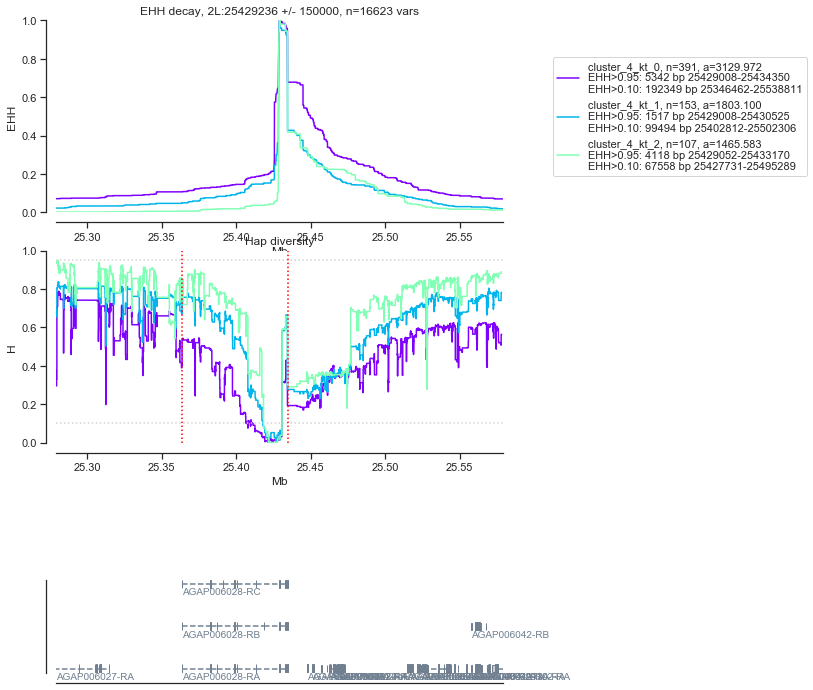

In [55]:
colors        = cm.rainbow(np.linspace(0, 1, len(clu_list_ids_fil)+3))
ehh_above_thr = 0.95
ehh_below_thr = 0.1
flank_bp_EHH  = 150000

# variants to retain
clu_varbool_up = np.logical_and(oc_hapvars_seg["POS"] >= loc_vari-flank_bp_EHH, oc_hapvars_seg["POS"] < loc_vari)
clu_varbool_do = np.logical_and(oc_hapvars_seg["POS"] > loc_vari, oc_hapvars_seg["POS"] <= loc_vari+flank_bp_EHH)
clu_varbool    = np.logical_or(clu_varbool_up,clu_varbool_do)
clu_varbool_genestart = np.logical_and(oc_hapvars_seg["POS"] > loc_start-1e4, oc_hapvars_seg["POS"] <= loc_start+1e4)
clu_varbool_geneend   = np.logical_and(oc_hapvars_seg["POS"] > loc_end-1e4, oc_hapvars_seg["POS"] <= loc_end+1e4)
clu_varbool_genecoreh = np.logical_and(oc_hapvars_seg["POS"] > loc_vari-1e4, oc_hapvars_seg["POS"] <= loc_vari+1e4)

# samples to remove from analysis (EHH function can't handle missing -1 data)
rmv_miss_ix   = np.unique(np.where(oc_haploty_hap_seg.subset(sel0=clu_varbool) == -1)[1]).tolist()
rmv_miss_bool = np.invert(np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=rmv_miss_ix))

# positions
clu_ehh_pos = oc_hapvars_seg["POS"].subset(sel0=clu_varbool)

# plot
pdf = PdfPages("%s/%s_%s.sel_EHHdecay_zoom_2Laaware.pdf" % (outdir,outcode,l_nom))
fig = plt.figure(figsize=(8,12))
ax3 = plt.subplot(3, 1, 1)

ax9 = plt.subplot(3, 1, 2)

j=0
for i,clui in enumerate([4]):
    clu_key = "cluster_"+str(clui)
    print("EHH %s" % clu_key)

    for _,ktj in enumerate([0,1,2]):
        
        # boolean for 2la karyotype
        kt_bool  = kary_df_hap["estimated_kt"] == ktj
        kt_bool  = kt_bool.values
        kt_bool  = np.isin(popdich_clu[clu_key], np.where(kt_bool)[0])
        kt_index = np.array(popdich_clu[clu_key]).compress(kt_bool).tolist()

        if sum(kt_bool)>1:
            
            # which variants include in the cluster-wise analysis of selection?
            clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=kt_index)
            clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)

            # calculate EHH
            clu_ehh_up_i = allel.ehh_decay(h=oc_haploty_hap_seg.subset(sel0=clu_varbool_up,sel1=clu_sambool))
            clu_ehh_do_i = allel.ehh_decay(h=oc_haploty_hap_seg.subset(sel0=clu_varbool_do,sel1=clu_sambool))
            clu_ehh_i    = np.concatenate((clu_ehh_up_i[::-1],clu_ehh_do_i))
            clu_ehh_i_ar = np.trapz(clu_ehh_i)
            ehh_above_start = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[0]
            ehh_above_end   = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[-1]
            ehh_below_start = clu_ehh_pos.compress(clu_ehh_i > ehh_below_thr)[0]
            ehh_below_end   = clu_ehh_pos.compress(clu_ehh_i > ehh_below_thr)[-1]
            
            # lab is data
            clu_lab    = "%s, n=%i, a=%.3f\nEHH>%.2f: %i bp %i-%i\nEHH>%.2f: %i bp %i-%i" % (
                clu_key+"_kt_"+str(ktj), len(kt_index),clu_ehh_i_ar, 
                ehh_above_thr, ehh_above_end-ehh_above_start, ehh_above_start, ehh_above_end,
                ehh_below_thr, ehh_below_end-ehh_below_start, ehh_below_start, ehh_below_end
            )

            # plot EHH background & foreground
            ax3.plot(clu_ehh_pos/1e6,clu_ehh_i,color=colors[j],label=clu_lab,mfc='none')
            
            # hap div
            clu_pos_wib    = allel.stats.moving_statistic(oc_hapvars_seg["POS"].subset(sel0=clu_varbool), statistic=lambda v: v[0], size=100, step=10)
            clu_hdi_wib    = allel.moving_haplotype_diversity(oc_haploty_hap_seg.subset(sel0=clu_varbool,sel1=clu_sambool), size=100, step=10)
            plt.subplot(3, 1, 2)
            plt.step(clu_pos_wib/1e6, clu_hdi_wib, color=colors[j])

            # haplotype diversity
            j_run = len(kt_index)
            j_hdi = np.zeros(shape=j_run)
            for k in range(j_run):
                j_sel1   = kt_index[0:k] + kt_index[k+1:j_run]
                j_hdi[k] = allel.haplotype_diversity(oc_haploty_hap_seg.subset(sel0=clu_varbool_genestart, sel1=j_sel1))
            j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_hdi)
            print("Hap div gene start %s \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clu_key+"_kt_"+str(ktj), j_av, j_se, j_cl, j_cu, j_nu))
            
            # haplotype diversity
            j_run = len(kt_index)
            j_hdi = np.zeros(shape=j_run)
            for k in range(j_run):
                j_sel1   = kt_index[0:k] + kt_index[k+1:j_run]
                j_hdi[k] = allel.haplotype_diversity(oc_haploty_hap_seg.subset(sel0=clu_varbool_geneend, sel1=j_sel1))
            j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_hdi)
            print("Hap div gene end %s \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clu_key+"_kt_"+str(ktj), j_av, j_se, j_cl, j_cu, j_nu))
            
            # haplotype diversity
            j_run = len(kt_index)
            j_hdi = np.zeros(shape=j_run)
            for k in range(j_run):
                j_sel1   = kt_index[0:k] + kt_index[k+1:j_run]
                j_hdi[k] = allel.haplotype_diversity(oc_haploty_hap_seg.subset(sel0=clu_varbool_genecoreh, sel1=j_sel1))
            j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_hdi)
            print("Hap div gene corehap %s \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clu_key+"_kt_"+str(ktj), j_av, j_se, j_cl, j_cu, j_nu))
            
            j=j+1

sns.despine(ax=ax3,offset=10)
ax3.set_title("EHH decay, %s:%i +/- %i, n=%s vars" % (chrom,loc_vari,flank_bp_EHH,clu_ehh_pos.shape[0]))
ax3.set_xlabel("Mb")
ax3.set_ylabel("EHH")
ax3.set_xlim(clu_ehh_pos[0]/1e6,clu_ehh_pos[-1]/1e6)
ax3.set_ylim(0,1)
plt.axhline(ehh_above_thr, color='lightgray',linestyle=":",label=str(ehh_above_thr))
plt.axhline(ehh_below_thr, color='lightgray',linestyle=":",label=str(ehh_below_thr))
plt.axvline(loc_start/1e6, color='red',linestyle=":",label="locus")
plt.axvline(loc_end/1e6, color='red',linestyle=":",label="")
plt.axvline(inv_start/1e6, color='orange',linestyle=":",label="inversion")
plt.axvline(inv_end/1e6, color='orange',linestyle=":",label="")
ax3.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

sns.despine(ax=ax9,offset=10)
ax9.set_title("Hap diversity")
ax9.set_xlim(clu_ehh_pos[0]/1e6,clu_ehh_pos[-1]/1e6)
ax9.set_ylim(0,1)
ax9.set_xlabel("Mb")
ax9.set_ylabel("H")

# plot transcripts
ax4 = plt.subplot(6, 1, 6)
sns.despine(ax=ax4,offset=10)
ax4.axes.get_xaxis().set_ticks([])
ax4.axes.get_xlabel() == ""
locus_genel = plot_transcripts(
    geneset=geneset,chrom=chrom,
    start=clu_ehh_pos[0],stop=clu_ehh_pos[-1],
    height=0.2,label_transcripts=True,ax=ax4,label_axis=False,
    color="slategray")

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

Calculate sequence divergence (Dxy) between 296G in 0 or 2 backgrounds and wt in 0 or 2 backgrounds. We expect:

* divergence between 296G and wt in the same background should be higher than divergence between 296G and wt from the opposite karyotype (ratio > 1 in the whole region)
* however, divergence between 296G-2La (2) and wt-2L+a (0) will be LOWER THAN EXPECTED AT THE 3' end, due to the inter-karyotypic introgression of the swept haplotype (ratio < 1 at 3')

sim cluster_4 0 391
sim cluster_4 0 593
(153639, 391) (153639, 593) (153639, 984)
sim cluster_4 0 391
sim cluster_4 0 500
(153639, 391) (153639, 500) (153639, 891)
sim cluster_4 2 107
sim cluster_4 2 593
(153639, 107) (153639, 593) (153639, 700)
sim cluster_4 2 107
sim cluster_4 2 500
(153639, 107) (153639, 500) (153639, 607)


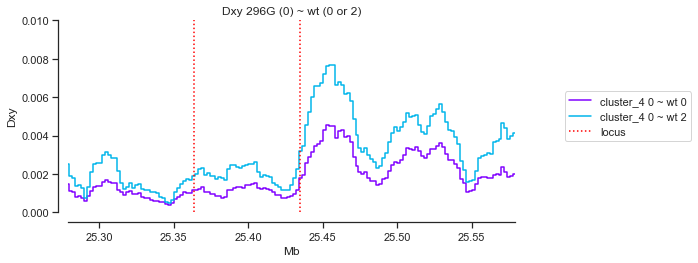

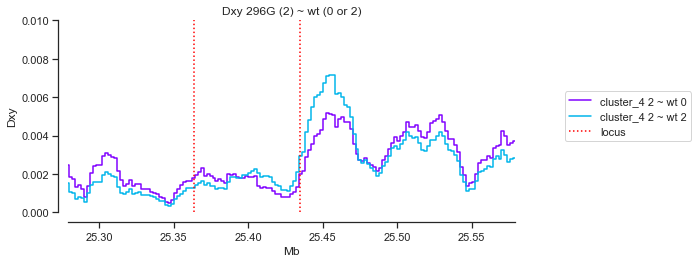

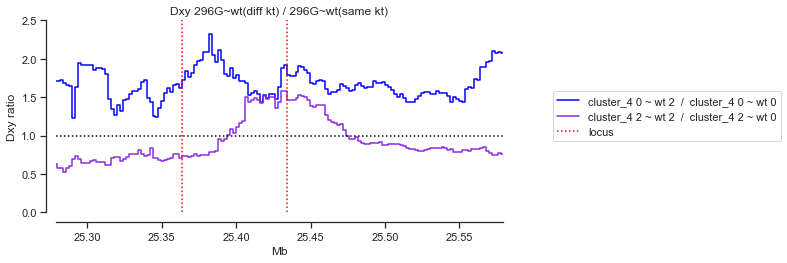

In [56]:
colors = cm.rainbow(np.linspace(0, 1, len(clu_list_ids_fil)+3))
oc_hapalco_div = dict()
clu_varbool = np.logical_and(oc_hapvars_seg["POS"] > loc_start-1e6, oc_hapvars_seg["POS"] <= loc_end+1e6)

pdf = PdfPages("%s/%s_%s.sel_seqdivergence_zoom_2Laaware.pdf" % (outdir,outcode,l_nom))

for i,clui in enumerate([4]):
    clu_key = "cluster_"+str(clui)

    for _,ktj in enumerate([0,2]):
        
        # boolean for 2la karyotype
        kt_bool  = kary_df_hap["estimated_kt"] == ktj
        kt_bool  = kt_bool.values
        kt_bool  = np.isin(popdich_clu[clu_key], np.where(kt_bool)[0])
        kt_index = np.array(popdich_clu[clu_key]).compress(kt_bool).tolist()

        fig = plt.figure(figsize=(8,12))
        ax3 = plt.subplot(3, 1, 1)
        j=0
       
        for _,ktjnoc in enumerate([0,2]):
            
        
            # boolean for 2la karyotype, for no cluster
            kt_bool_noc  = kary_df_hap["estimated_kt"] == ktjnoc
            kt_bool_noc  = kt_bool_noc.values
            kt_bool_noc  = np.isin(popdich_clu["cluster_no"], np.where(kt_bool_noc)[0])
            kt_index_noc = np.array(popdich_clu["cluster_no"]).compress(kt_bool_noc).tolist()

            if sum(kt_bool)>1:
            
                # which variants include in the cluster-wise analysis of selection?
                clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=kt_index)
                # which variants include in the cluster-wise analysis of selection?
                clu_sambool_noc = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=kt_index_noc)

                print("sim %s %i %i" % (clu_key,ktj,sum(clu_sambool)))
                print("sim %s %i %i" % (clu_key,ktj,sum(clu_sambool_noc)))

                oc_haploty_hap_seg_ktclu = oc_haploty_hap_seg.subset(sel0=clu_varbool,sel1=clu_sambool)
                oc_haploty_hap_seg_ktnoc = oc_haploty_hap_seg.subset(sel0=clu_varbool,sel1=clu_sambool_noc)
                oc_haploty_hap_seg_kt    = np.hstack((oc_haploty_hap_seg_ktclu,oc_haploty_hap_seg_ktnoc))
                print(oc_haploty_hap_seg_ktclu.shape,oc_haploty_hap_seg_ktnoc.shape,oc_haploty_hap_seg_kt.shape)


                # dict
                oc_popdickar = dict()
                oc_popdickar["clu"] = list(range(0,oc_haploty_hap_seg_ktclu.shape[1]))
                oc_popdickar["noc"] = list(range(oc_haploty_hap_seg_ktclu.shape[1],oc_haploty_hap_seg_kt.shape[1]))

                # allele counts
                oc_hapalco_tmp = allel.HaplotypeChunkedArray(oc_haploty_hap_seg_kt).count_alleles_subpops(subpops=oc_popdickar)

                # divergence clu to wt
                label = clu_key+" "+str(ktj)+" ~ wt "+str(ktjnoc)
                oc_hapalco_div[label] = allel.windowed_divergence(ac1=oc_hapalco_tmp["clu"],ac2=oc_hapalco_tmp["noc"],pos=oc_hapvars_seg["POS"].subset(sel0=clu_varbool), size=20000,step=2000)

                
                plt.step(oc_hapalco_div[label][1][:,0]/1e6, oc_hapalco_div[label][0], color=colors[j], label=label)
                sns.despine(ax=ax3,offset=10)
                
            
            j=j+1
        plt.axvline(loc_start/1e6, color='red',linestyle=":",label="locus")
        plt.axvline(loc_end/1e6, color='red',linestyle=":",label="")
        ax3.set_ylim(0,0.01)
        ax3.set_xlim(clu_ehh_pos[0]/1e6,clu_ehh_pos[-1]/1e6)
        ax3.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
        ax3.set_xlabel("Mb")
        ax3.set_ylabel("Dxy")
        ax3.set_title("Dxy 296G (%s) ~ wt (0 or 2)" % ktj)
        pdf.savefig(fig,bbox_inches='tight')


# plot ratio
fig = plt.figure(figsize=(8,12))
ax3 = plt.subplot(3, 1, 1)
sns.despine(ax=ax3,offset=10)
plt.step(oc_hapalco_div["cluster_4 2 ~ wt 2"][1][:,0]/1e6, 
         oc_hapalco_div["cluster_4 0 ~ wt 2"][0] / oc_hapalco_div["cluster_4 0 ~ wt 0"][0], 
         color="blue",   label="cluster_4 0 ~ wt 2  /  cluster_4 0 ~ wt 0")
plt.step(oc_hapalco_div["cluster_4 2 ~ wt 2"][1][:,0]/1e6, 
         oc_hapalco_div["cluster_4 2 ~ wt 2"][0] / oc_hapalco_div["cluster_4 2 ~ wt 0"][0], 
         color="m", label="cluster_4 2 ~ wt 2  /  cluster_4 2 ~ wt 0")
plt.axhline(1, color='black',linestyle=":",label="")
plt.axvline(loc_start/1e6, color='red',linestyle=":",label="locus")
plt.axvline(loc_end/1e6, color='red',linestyle=":",label="")
ax3.set_xlim(clu_ehh_pos[0]/1e6,clu_ehh_pos[-1]/1e6)
ax3.set_ylim(0,2.5)
ax3.set_xlabel("Mb")
ax3.set_ylabel("Dxy ratio")
ax3.set_title("Dxy 296G~wt(diff kt) / 296G~wt(same kt)")
ax3.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

### Genetic differentiation in the core haplotype

First, normalised hamming distance between haplotypes, in a pairwise fashion:

In [57]:
corehap_varbool = np.logical_and(oc_hapvars_seg["POS"] > loc_vari-fbp_hap, oc_hapvars_seg["POS"] < loc_vari+fbp_hap)
corehap_saminxs = np.append(np.append(popdich_clu["cluster_4"], popdich_clu["cluster_34"]),popdich_clu["cluster_no"])
#corehap_saminxs = np.append(popdich_clu["cluster_4"], popdich_clu["cluster_34"])
corehap_genomat = oc_haploty_hap_seg.subset(
    sel0=corehap_varbool, sel1=corehap_saminxs )
corehap_genomat.shape

(626, 2356)

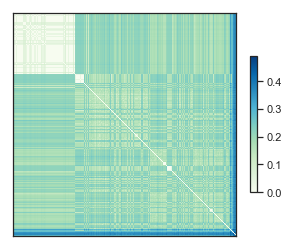

In [58]:
pdf = PdfPages("%s/%s_%s.distmat.pdf" % (outdir,outcode,l_nom))

corehap_genodis = allel.pairwise_distance(
    corehap_genomat[:],
    metric="hamming")
arg_dic = {"cmap": "GnBu"}
fig = plt.figure(figsize=(5,5))
ax2 = plt.subplot(1, 1, 1)
allel.plot_pairwise_distance(np.sqrt(corehap_genodis),
                                   colorbar=True, 
                                   imshow_kwargs=arg_dic,ax=ax2)

pdf.savefig(fig,bbox_inches='tight')
pdf.close()

Second, Fst between groups of haplotypes:

In [59]:
block_len_snp = 5000
step_frac_snp = 0.2
step_perc_snp = int(step_frac_snp * 100)
step_len_snp  = int(block_len_snp * step_frac_snp)

def loop_Fst(name, popA_list, popC_list, 
             popA_ac, popC_ac,
             pos,cycle = "C", block_len_snp=block_len_snp, step_len_snp=step_len_snp,
             color=["blue","darkorange","turquoise","crimson","magenta","limegreen",
                    "forestgreen","slategray","orchid","darkblue"]):
    
    windows_pos = allel.stats.moving_statistic(pos, statistic=lambda v: v[0], size=block_len_snp,step=step_len_snp)

    # calculate pvalues and focus in this region: duplicated region proper
    is_locus = np.logical_and(pos > loc_start,pos < loc_end) # gene region
    is_inv   = np.logical_and(pos > inv_start,pos < inv_end) # inversion region
    
    # loop
    pdf = PdfPages("%s/%s.Fst_%s.pdf" % (outdir,outcode,name))
        
    colors = cm.rainbow(np.linspace(0, 1, len(popC_list)))

    for an,popA in enumerate(popA_list):

        fig = plt.figure(figsize=(15,3))

        # whole chromosome: frame
        ax1 = plt.subplot(1, 2, 1)
        sns.despine(ax=ax1,offset=10)
        ax1.set_title("Chr %s Fst %s~X" % (chrom,popA))
        ax1.set_xlim(0,50)
        ax1.set_ylim(0,1)
        ax1.set_xlabel("Mb")
        ax1.set_ylabel("Fst")
        plt.axhline(0, color='k',linestyle="--",label="")
        plt.axvline(loc_start/1e6, color='red',linestyle=":",label="locus")
        plt.axvline(loc_end/1e6, color='red',linestyle=":",label="")
        plt.axvline(inv_start/1e6, color='orange',linestyle=":",label="inversion")
        plt.axvline(inv_end/1e6, color='orange',linestyle=":",label="")

        ax2 = plt.subplot(1, 4, 3)
        sns.despine(ax=ax2,offset=10)
        ax2.set_xlim(loc_start/1e6-0.5,loc_end/1e6+0.5)
        ax2.set_ylim(0,1)
        ax2.set_xlabel("Mb")
        ax2.set_ylabel("Fst")
        plt.axhline(0, color='k',linestyle="--",label="")
        plt.axvline(loc_start/1e6, color='red',linestyle=":",label="locus")
        plt.axvline(loc_end/1e6, color='red',linestyle=":",label="")
        plt.axvline(inv_start/1e6, color='orange',linestyle=":",label="inversion")
        plt.axvline(inv_end/1e6, color='orange',linestyle=":",label="")

        for cn,popC in enumerate(popC_list):

            if popA != popC:

                # block-wise patterson D (normalised)
                admix_pd_n_win = allel.moving_hudson_fst( 
                    ac1=popA_ac[popA][:,0:2],
                    ac2=popC_ac[popC][:,0:2],
                    size=block_len_snp,step=step_len_snp)

                # whole chromosome: plot
                plt.subplot(1, 2, 1)
                plt.step(windows_pos/1e6, admix_pd_n_win, color=colors[cn])

                # estimated D in locus with pval
                admix_pd_av_indup = allel.average_hudson_fst(
                    ac1=popA_ac[popA][:,0:2][is_locus],
                    ac2=popC_ac[popC][:,0:2][is_locus],
                    blen=100)
                # zoomed region: plot
                plt.subplot(1, 4, 3)
                plt.step(windows_pos/1e6, admix_pd_n_win, color=colors[cn], 
                         label="%s\nFst = %.3f +/- %.3f" % 
                             (popC,admix_pd_av_indup[0],admix_pd_av_indup[1]))

        plt.axhline(0, color='k',linestyle="--",label="")
        ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

        # save pdf
        pdf.savefig(fig,bbox_inches='tight')

    pdf.close()

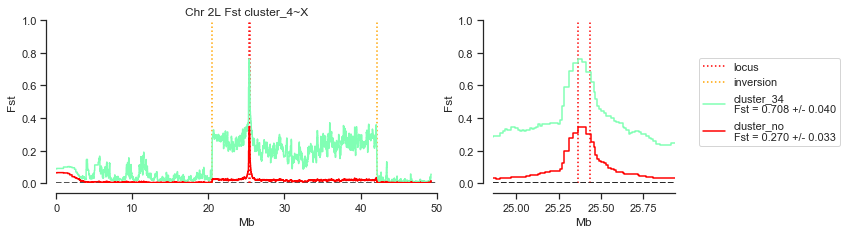

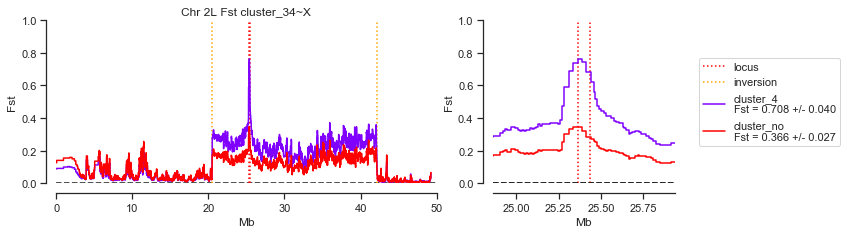

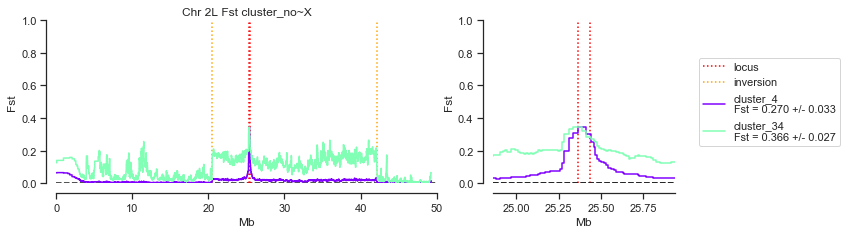

In [60]:
%%capture --no-stdout --no-display
loop_Fst(
    name="corehap",
    popA_list=["cluster_4","cluster_34","cluster_no"],
    popC_list=["cluster_4","cluster_34","cluster_no"],
    popA_ac=oc_hapalco_hap_clu_seg, 
    popC_ac=oc_hapalco_hap_clu_seg, 
    pos=oc_hapvars_seg["POS"],
    cycle="C"
)

### Sequence diversity

Sequence diversity in each haplotype group:

In [61]:
varbool_loc   = np.logical_and(oc_hapvars_seg["POS"] >= loc_start, oc_hapvars_seg["POS"] <= loc_end)
varbool_syn   = np.asarray([oc_genveff_seg_ann[i].split("|")[1] == "synonymous_variant" for i,_ in enumerate(oc_genveff_seg_ann)])
varbool_nosyn = is_coding

for popi in ["cluster_34","cluster_4","cluster_no"]:

    j_run    = len(popdich_clu[popi])
    j_pi_s   = np.zeros(shape=j_run)
    j_pi_n   = np.zeros(shape=j_run)
    j_pi_n_s = np.zeros(shape=j_run)
    for i in range(j_run):
        j_sel1      = popdich_clu[popi][0:i] + popdich_clu[popi][i+1:j_run]
        j_dic       = dict()
        j_dic[popi] = j_sel1
        j_dic_n_ac  = oc_haploty_hap_seg.subset(sel0=np.logical_and(varbool_loc, varbool_nosyn)).count_alleles_subpops(subpops=j_dic)
        j_dic_s_ac  = oc_haploty_hap_seg.subset(sel0=np.logical_and(varbool_loc, varbool_syn)).count_alleles_subpops(subpops=j_dic)
        j_pi_n[i]   = allel.sequence_diversity(pos=oc_hapvars_seg["POS"].subset(sel0=np.logical_and(varbool_loc, varbool_nosyn)), ac=j_dic_n_ac[popi])
        j_pi_s[i]   = allel.sequence_diversity(pos=oc_hapvars_seg["POS"].subset(sel0=np.logical_and(varbool_loc, varbool_syn)),   ac=j_dic_s_ac[popi])
        j_pi_n_s[i] = j_pi_n[i] / j_pi_s[i]

    j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_pi_n)
    print("pi_n %s \t = %.3E +/- %.3E SE, %.3E-%.3E CI95, n=%i" % (popi, j_av, j_se, j_cl, j_cu, j_nu))
    j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_pi_s)
    print("pi_s %s \t = %.3E +/- %.3E SE, %.3E-%.3E CI95, n=%i" % (popi, j_av, j_se, j_cl, j_cu, j_nu))
    j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_pi_n_s)
    print("r_n_s %s\t = %.3E +/- %.3E SE, %.3E-%.3E CI95, n=%i" % (popi, j_av, j_se, j_cl, j_cu, j_nu))
                    


pi_n cluster_34 	 = 3.442E-06 +/- 1.294E-07 SE, 2.923E-06-3.477E-06 CI95, n=94
pi_s cluster_34 	 = 7.103E-06 +/- 9.876E-09 SE, 7.093E-06-7.112E-06 CI95, n=94
r_n_s cluster_34	 = 4.846E-01 +/- 1.814E-02 SE, 4.121E-01-4.903E-01 CI95, n=94
pi_n cluster_4 	 = 6.728E-06 +/- 1.525E-08 SE, 6.702E-06-6.737E-06 CI95, n=651
pi_s cluster_4 	 = 2.771E-06 +/- 1.233E-08 SE, 2.738E-06-2.775E-06 CI95, n=651
r_n_s cluster_4	 = 2.428E+00 +/- 9.946E-03 SE, 2.417E+00-2.447E+00 CI95, n=651
pi_n cluster_no 	 = 1.132E-06 +/- 4.684E-09 SE, 1.132E-06-1.133E-06 CI95, n=1611
pi_s cluster_no 	 = 8.398E-06 +/- 9.418E-09 SE, 8.369E-06-8.403E-06 CI95, n=1611
r_n_s cluster_no	 = 1.348E-01 +/- 5.859E-04 SE, 1.348E-01-1.353E-01 CI95, n=1611


### Garud H

Compute **Garud H** for each cluster, along the entire chromosome, to see landscape:

Retain...
Garud H cluster_4 - chr...
Hap div cluster_4 - chr...
Plots   cluster_4...
Garud H cluster_34 - chr...
Hap div cluster_34 - chr...
Plots   cluster_34...
Garud H cluster_no - chr...
Hap div cluster_no - chr...
Plots   cluster_no...


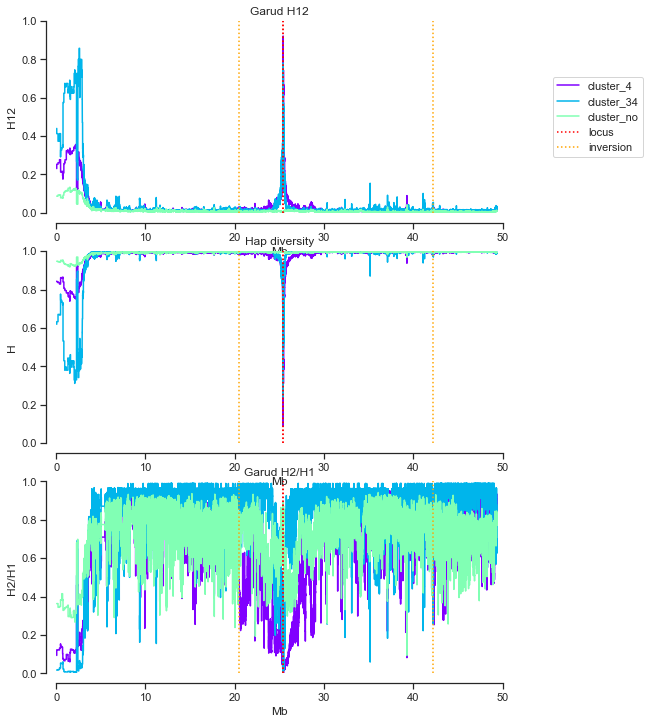

In [62]:
# parameters
block_len_hap = 500   # for the whole-genome view
step_len_hap  = 100   # for the whole-genome view
colors        = cm.rainbow(np.linspace(0, 1, len(clu_list_ids_fil)+3))
fbp_hap_extra = 1e6

# variants to retain
print("Retain...")
clu_pos_wib    = allel.stats.moving_statistic(oc_hapvars_seg["POS"], statistic=lambda v: v[0], size=block_len_hap,step=step_len_hap)

# open pdf
pdf = PdfPages("%s/%s_%s.sel_garudH.pdf" % (outdir,outcode,l_nom))
fig = plt.figure(figsize=(8,12))

# whole chromosome: frame
ax1 = plt.subplot(3, 1, 1)
sns.despine(ax=ax1,offset=10)
ax1.set_title("Garud H12")
ax1.set_xlim(ret_start/1e6,50)
ax1.set_ylim(0,1)
ax1.set_xlabel("Mb")
ax1.set_ylabel("H12")

ax2 = plt.subplot(3, 1, 3)
sns.despine(ax=ax2,offset=10)
ax2.set_title("Garud H2/H1")
ax2.set_xlim(ret_start/1e6,50)
ax2.set_ylim(0,1)
ax2.set_xlabel("Mb")
ax2.set_ylabel("H2/H1")

ax3 = plt.subplot(3, 1, 2)
sns.despine(ax=ax3,offset=10)
ax3.set_title("Hap diversity")
ax3.set_xlim(ret_start/1e6,50)
ax3.set_ylim(0,1)
ax3.set_xlabel("Mb")
ax3.set_ylabel("H")

for i,clui in enumerate(np.append(clu_list_ids_fil,"no")):
    
    # which variants include in the cluster-wise analysis of selection?
    clu_key     = "cluster_"+str(clui)
    clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=popdich_clu[clu_key])
        
    # selection: Garud's H
    print("Garud H %s - chr..." % clu_key)
    clu_gah_wib = allel.moving_garud_h(oc_haploty_hap_seg.subset(sel1=popdich_clu[clu_key]), size=block_len_hap, step=step_len_hap)

    # haplotype diversity
    print("Hap div %s - chr..." % clu_key)
    clu_hdi_wib = allel.moving_haplotype_diversity(oc_haploty_hap_seg.subset(sel1=popdich_clu[clu_key]), size=block_len_hap, step=step_len_hap)
    
    print("Plots   %s..." % clu_key)
    # plot H12
    plt.subplot(3, 1, 1)
    plt.step(clu_pos_wib/1e6, clu_gah_wib[1], color=colors[i], label=clu_key)
        
    # plot H2H1
    plt.subplot(3, 1, 3)
    plt.step(clu_pos_wib/1e6, clu_gah_wib[3], color=colors[i])

    # plot hap div
    plt.subplot(3, 1, 2)
    plt.step(clu_pos_wib/1e6, clu_hdi_wib, color=colors[i])

plt.subplot(3, 1, 1)
plt.axvline(loc_start/1e6, color='red',linestyle=":",label="locus")
plt.axvline(loc_end/1e6, color='red',linestyle=":",label="")
plt.axvline(inv_start/1e6, color='orange',linestyle=":",label="inversion")
plt.axvline(inv_end/1e6, color='orange',linestyle=":",label="")
ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.axvline(2358158, color='brown',linestyle=":",label="Vgsc")
plt.axvline(2431617, color='brown',linestyle=":",label="")

plt.subplot(3, 1, 3)
plt.axvline(loc_start/1e6, color='red',linestyle=":",label="locus")
plt.axvline(loc_end/1e6, color='red',linestyle=":",label="")
plt.axvline(inv_start/1e6, color='orange',linestyle=":",label="inversion")
plt.axvline(inv_end/1e6, color='orange',linestyle=":",label="")
plt.axvline(2358158, color='brown',linestyle=":",label="Vgsc")
plt.axvline(2431617, color='brown',linestyle=":",label="")

plt.subplot(3, 1, 2)
plt.axvline(loc_start/1e6, color='red',linestyle=":",label="locus")
plt.axvline(loc_end/1e6, color='red',linestyle=":",label="")
plt.axvline(inv_start/1e6, color='orange',linestyle=":",label="inversion")
plt.axvline(inv_end/1e6, color='orange',linestyle=":",label="")
plt.axvline(2358158, color='brown',linestyle=":",label="Vgsc")
plt.axvline(2431617, color='brown',linestyle=":",label="")

pdf.savefig(fig,bbox_inches='tight')
pdf.close()

### Calculate selection statistics in the loci of interest

Zoom into Rdl locus or core haplotype and recalculate local Garud H and haplotype diversity, with jack-knifing of samples.

* **jack-knifing**: remove one sample (specimen) at a time without replacement and recalculate the statistic $n$ times ($n$=number of samples in each group, which will vary according to each haplotype cluster). This is the appropiate procedure for haplotype similarity statistics: a priori, the iterative removal of samples can both increase or decrease the statistic, which makes it a good measure of the robustness of the estimate.
* **bootstraping**: resample specimens with replacement, for $n=100$ iterations (where the number of samples in each iteration equals the number of samples in each group). This is **not adequate** for this particular statistic, because when you resample with replacement you're introducing duplicated samples that will always result in an upwards bias for statistics that measure haplotype similarity.

Selection statistics within core haplotype:

In [63]:
clu_varbool    = np.logical_and(oc_hapvars_seg["POS"] >= loc_vari-fbp_hap , oc_hapvars_seg["POS"] <= loc_vari+fbp_hap)

for i,clui in enumerate(np.append(clu_list_ids_fil,"no")):

    # cluster key
    clu_key     = "cluster_"+str(clui)
    print("Locus: %i vars, cluster %s" % (sum(clu_varbool),clu_key))
    
    # haplotype diversity
    j_run = len(popdich_clu[clu_key])
    j_hdi = np.zeros(shape=j_run)
    for i in range(j_run):
        j_sel1   = popdich_clu[clu_key][0:i] + popdich_clu[clu_key][i+1:j_run]
        j_hdi[i] = allel.haplotype_diversity(oc_haploty_hap_seg.subset(sel0=clu_varbool, sel1=j_sel1))
    j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_hdi)
    print("Hap div %s \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clu_key, j_av, j_se, j_cl, j_cu, j_nu))

    # Garud H12
    j_run  = len(popdich_clu[clu_key])
    j_h12  = np.zeros(shape=j_run)
    j_h2h1 = np.zeros(shape=j_run)
    for i in range(j_run):
        j_sel1    = popdich_clu[clu_key][0:i] + popdich_clu[clu_key][i+1:j_run]
        j_hstat   = allel.garud_h(oc_haploty_hap_seg.subset(sel0=clu_varbool, sel1=j_sel1))
        j_h12[i]  = j_hstat[1]
        j_h2h1[i] = j_hstat[3]
    j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_h12)
    print("H12 %s     \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clu_key, j_av, j_se, j_cl, j_cu, j_nu))
    j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_h2h1)
    print("H2H1 %s    \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clu_key, j_av, j_se, j_cl, j_cu, j_nu))    

Locus: 626 vars, cluster cluster_4
Hap div cluster_4 	 = 0.501118 +/- 0.000871 SE, 0.499580-0.501700 CI95, n=651
H12 cluster_4     	 = 0.698387 +/- 0.000923 SE, 0.697974-0.700535 CI95, n=651
H2H1 cluster_4    	 = 0.052180 +/- 0.000382 SE, 0.051341-0.052400 CI95, n=651
Locus: 626 vars, cluster cluster_34
Hap div cluster_34 	 = 0.377259 +/- 0.006790 SE, 0.363721-0.380785 CI95, n=94
H12 cluster_34     	 = 0.744031 +/- 0.006386 SE, 0.741473-0.759972 CI95, n=94
H2H1 cluster_34    	 = 0.011238 +/- 0.000692 SE, 0.008869-0.011501 CI95, n=94
Locus: 626 vars, cluster cluster_no
Hap div cluster_no 	 = 0.998090 +/- 0.000006 SE, 0.998088-0.998108 CI95, n=1611
H12 cluster_no     	 = 0.003362 +/- 0.000010 SE, 0.003315-0.003366 CI95, n=1611
H2H1 cluster_no    	 = 0.756319 +/- 0.001510 SE, 0.754827-0.756246 CI95, n=1611


Now, selection statistics within the gene of interest:

In [64]:
clu_varbool    = np.logical_and(oc_hapvars_seg["POS"] >= loc_start , oc_hapvars_seg["POS"] <= loc_end)

for i,clui in enumerate(np.append(clu_list_ids_fil,"no")):

    # cluster key
    clu_key     = "cluster_"+str(clui)
    print("Locus: %i vars, cluster %s" % (sum(clu_varbool),clu_key))
    
    # haplotype diversity
    j_run = len(popdich_clu[clu_key])
    j_hdi = np.zeros(shape=j_run)
    for i in range(j_run):
        j_sel1   = popdich_clu[clu_key][0:i] + popdich_clu[clu_key][i+1:j_run]
        j_hdi[i] = allel.haplotype_diversity(oc_haploty_hap_seg.subset(sel0=clu_varbool, sel1=j_sel1))
    j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_hdi)
    print("Hap div %s \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clu_key, j_av, j_se, j_cl, j_cu, j_nu))

    # Garud H12
    j_run  = len(popdich_clu[clu_key])
    j_h12  = np.zeros(shape=j_run)
    j_h2h1 = np.zeros(shape=j_run)
    for i in range(j_run):
        j_sel1    = popdich_clu[clu_key][0:i] + popdich_clu[clu_key][i+1:j_run]
        j_hstat   = allel.garud_h(oc_haploty_hap_seg.subset(sel0=clu_varbool, sel1=j_sel1))
        j_h12[i]  = j_hstat[1]
        j_h2h1[i] = j_hstat[3]
    j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_h12)
    print("H12 %s     \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clu_key, j_av, j_se, j_cl, j_cu, j_nu))
    j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_h2h1)
    print("H2H1 %s    \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clu_key, j_av, j_se, j_cl, j_cu, j_nu))    

Locus: 3003 vars, cluster cluster_4
Hap div cluster_4 	 = 0.885587 +/- 0.000451 SE, 0.885234-0.886230 CI95, n=651
H12 cluster_4     	 = 0.172533 +/- 0.000617 SE, 0.171796-0.173060 CI95, n=651
H2H1 cluster_4    	 = 0.092625 +/- 0.000791 SE, 0.090517-0.093413 CI95, n=651
Locus: 3003 vars, cluster cluster_34
Hap div cluster_34 	 = 0.975063 +/- 0.001070 SE, 0.974521-0.977560 CI95, n=94
H12 cluster_34     	 = 0.051264 +/- 0.001656 SE, 0.047982-0.052145 CI95, n=94
H2H1 cluster_34    	 = 0.373739 +/- 0.014512 SE, 0.353135-0.407018 CI95, n=94
Locus: 3003 vars, cluster cluster_no
Hap div cluster_no 	 = 0.999387 +/- 0.000003 SE, 0.999386-0.999395 CI95, n=1611
H12 cluster_no     	 = 0.001484 +/- 0.000004 SE, 0.001476-0.001485 CI95, n=1611
H2H1 cluster_no    	 = 0.804807 +/- 0.001583 SE, 0.803583-0.804687 CI95, n=1611


Now, positive selection statistics in Vgsc:

In [65]:
clu_varbool    = np.logical_and(oc_hapvars_seg["POS"] >= 2358158 , oc_hapvars_seg["POS"] <= 2431617)

for i,clui in enumerate(np.append(clu_list_ids_fil,"no")):

    # cluster key
    clu_key     = "cluster_"+str(clui)
    print("Locus: %i vars, cluster %s" % (sum(clu_varbool),clu_key))
    
    # haplotype diversity
    j_run = len(popdich_clu[clu_key])
    j_hdi = np.zeros(shape=j_run)
    for i in range(j_run):
        j_sel1   = popdich_clu[clu_key][0:i] + popdich_clu[clu_key][i+1:j_run]
        j_hdi[i] = allel.haplotype_diversity(oc_haploty_hap_seg.subset(sel0=clu_varbool, sel1=j_sel1))
    j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_hdi)
    print("Hap div %s \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clu_key, j_av, j_se, j_cl, j_cu, j_nu))

    # Garud H12
    j_run  = len(popdich_clu[clu_key])
    j_h12  = np.zeros(shape=j_run)
    j_h2h1 = np.zeros(shape=j_run)
    for i in range(j_run):
        j_sel1    = popdich_clu[clu_key][0:i] + popdich_clu[clu_key][i+1:j_run]
        j_hstat   = allel.garud_h(oc_haploty_hap_seg.subset(sel0=clu_varbool, sel1=j_sel1))
        j_h12[i]  = j_hstat[1]
        j_h2h1[i] = j_hstat[3]
    j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_h12)
    print("H12 %s     \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clu_key, j_av, j_se, j_cl, j_cu, j_nu))
    j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_h2h1)
    print("H2H1 %s    \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clu_key, j_av, j_se, j_cl, j_cu, j_nu))    

Locus: 434 vars, cluster cluster_4
Hap div cluster_4 	 = 0.919055 +/- 0.000238 SE, 0.918805-0.919450 CI95, n=651
H12 cluster_4     	 = 0.130849 +/- 0.000428 SE, 0.130249-0.131247 CI95, n=651
H2H1 cluster_4    	 = 0.462265 +/- 0.002040 SE, 0.459947-0.465897 CI95, n=651
Locus: 434 vars, cluster cluster_34
Hap div cluster_34 	 = 0.853123 +/- 0.002180 SE, 0.849930-0.855774 CI95, n=94
H12 cluster_34     	 = 0.267853 +/- 0.004495 SE, 0.263267-0.273442 CI95, n=94
H2H1 cluster_34    	 = 0.509676 +/- 0.012778 SE, 0.495899-0.529013 CI95, n=94
Locus: 434 vars, cluster cluster_no
Hap div cluster_no 	 = 0.968122 +/- 0.000044 SE, 0.968082-0.968208 CI95, n=1611
H12 cluster_no     	 = 0.048403 +/- 0.000081 SE, 0.048240-0.048463 CI95, n=1611
H2H1 cluster_no    	 = 0.680926 +/- 0.000951 SE, 0.679970-0.683574 CI95, n=1611


Same thing, around Vgsc's 995th codon:

In [66]:
clu_varbool    = np.logical_and(oc_hapvars_seg["POS"] >= 2422651-6000 , oc_hapvars_seg["POS"] <= 2422651+6000) # lengths from Clarkson et al biorxiv 2018

for i,clui in enumerate(np.append(clu_list_ids_fil,"no")):

    # cluster key
    clu_key     = "cluster_"+str(clui)
    print("Locus: %i vars, cluster %s" % (sum(clu_varbool),clu_key))
    
    # haplotype diversity
    j_run = len(popdich_clu[clu_key])
    j_hdi = np.zeros(shape=j_run)
    for i in range(j_run):
        j_sel1   = popdich_clu[clu_key][0:i] + popdich_clu[clu_key][i+1:j_run]
        j_hdi[i] = allel.haplotype_diversity(oc_haploty_hap_seg.subset(sel0=clu_varbool, sel1=j_sel1))
    j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_hdi)
    print("Hap div %s \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clu_key, j_av, j_se, j_cl, j_cu, j_nu))

    # Garud H12
    j_run  = len(popdich_clu[clu_key])
    j_h12  = np.zeros(shape=j_run)
    j_h2h1 = np.zeros(shape=j_run)
    for i in range(j_run):
        j_sel1    = popdich_clu[clu_key][0:i] + popdich_clu[clu_key][i+1:j_run]
        j_hstat   = allel.garud_h(oc_haploty_hap_seg.subset(sel0=clu_varbool, sel1=j_sel1))
        j_h12[i]  = j_hstat[1]
        j_h2h1[i] = j_hstat[3]
    j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_h12)
    print("H12 %s     \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clu_key, j_av, j_se, j_cl, j_cu, j_nu))
    j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_h2h1)
    print("H2H1 %s    \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clu_key, j_av, j_se, j_cl, j_cu, j_nu))    

Locus: 93 vars, cluster cluster_4
Hap div cluster_4 	 = 0.710651 +/- 0.000693 SE, 0.709759-0.711324 CI95, n=651
H12 cluster_4     	 = 0.412282 +/- 0.000870 SE, 0.411617-0.413548 CI95, n=651
H2H1 cluster_4    	 = 0.109909 +/- 0.000688 SE, 0.108782-0.110498 CI95, n=651
Locus: 93 vars, cluster cluster_34
Hap div cluster_34 	 = 0.282315 +/- 0.006051 SE, 0.266947-0.284946 CI95, n=94
H12 cluster_34     	 = 0.917393 +/- 0.004131 SE, 0.916522-0.936871 CI95, n=94
H2H1 cluster_34    	 = 0.019975 +/- 0.001203 SE, 0.016701-0.020448 CI95, n=94
Locus: 93 vars, cluster cluster_no
Hap div cluster_no 	 = 0.906096 +/- 0.000124 SE, 0.905979-0.906297 CI95, n=1611
H12 cluster_no     	 = 0.147299 +/- 0.000199 SE, 0.147035-0.147481 CI95, n=1611
H2H1 cluster_no    	 = 0.304288 +/- 0.000665 SE, 0.303345-0.305313 CI95, n=1611


## Export FASTA

Prepare sequence names. First, genotype in 296th codon:

In [67]:
oc_sampleh["296_SG_genotype"] = loc_gty_T.astype(str)

Add info from 2La karyotype:

In [68]:
kary_df = pd.read_csv(kary_fn, sep='\t')
kary_df = kary_df.loc[kary_df['population'].isin(oc_popl)]
print("karyotypes 2La phase2:",kary_df.shape)

kary_df_hap = pd.DataFrame(data={
    "ox_code"     : list(itertools.chain(*[[ s + 'a', s + 'b'] for s in kary_df["ox_code"].values.tolist()])),    
    "estimated_kt" : list(itertools.chain(*[[ s      , s      ] for s in kary_df["estimated_kt"].values.tolist()]))
})

kary_df_hap.shape

karyotypes 2La phase2: (1178, 4)


(2356, 2)

Create alignment dataframe:

In [69]:
happhy = pd.DataFrame({
    "hap": ">"+oc_sampleh["ox_code"]+"_"+oc_sampleh["population"]+"_gt"+oc_sampleh["296_SG_genotype"]+"_kt"+kary_df_hap["estimated_kt"].astype(str),
    "seq": np.nan},    
    columns=["hap", "seq"])
happhy.head()

,hap,seq
0,>AA0040-Ca_GHcol_gt2_kt0,NaN
1,>AA0040-Cb_GHcol_gt2_kt0,NaN
2,>AA0041-Ca_GHcol_gt2_kt2,NaN
3,>AA0041-Cb_GHcol_gt2_kt2,NaN
4,>AA0042-Ca_GHcol_gt2_kt0,NaN


#### FASTA *Rdl*

In [70]:
export_name        = "loc" 
loc_varbool        = np.logical_and(oc_hapvars_seg["POS"][:] >= loc_start, oc_hapvars_seg["POS"][:] <= loc_end)
fa_haploty_hap_seg = oc_haploty_hap_seg.compress(loc_varbool)
fa_hapvars_seg     = oc_hapvars_seg.compress(loc_varbool)
print(export_name,fa_haploty_hap_seg.shape, fa_hapvars_seg.shape)

for pn,popi in enumerate(oc_sampleh["ox_code"]):
    
    if pn % int(happhy.shape[0]/10) == 0 : print(pn,"/",happhy.shape[0])
    popi_gen = np.ndarray.tolist(fa_haploty_hap_seg[:,pn])
    popi_seq = [fa_hapvars_seg["REF"][gn].astype(str) if gei == 0 else fa_hapvars_seg["ALT"][gn].astype(str) for gn,gei in enumerate(popi_gen)]
    happhy["seq"][pn] = ''.join(str(e) for e in popi_seq)

print(pn,"/",happhy.shape[0])
happhy.to_csv("%s/%s_%s.alig_%s.fasta" % (outdir,outcode,l_nom,export_name),sep="\n",index=False, header=False)
pd.DataFrame({
    "POS" : oc_hapvars_seg["POS"].subset(loc_varbool)[:]  
}).to_csv("%s/%s_%s.alig_%s.pos" % (outdir,outcode,l_nom,export_name),sep="\n",index=False, header=False)

loc (3003, 2356) (3003,)
0 / 2356
235 / 2356
470 / 2356
705 / 2356
940 / 2356
1175 / 2356
1410 / 2356
1645 / 2356
1880 / 2356
2115 / 2356
2350 / 2356
2355 / 2356


#### FASTA *Rdl* core hap

Haplotype region around 296th codon only:

In [71]:
export_name        = "corehap" 
loc_varbool        = np.logical_and(oc_hapvars_seg["POS"][:] >= loc_vari - fbp_hap, oc_hapvars_seg["POS"][:] <= loc_vari + fbp_hap)
fa_haploty_hap_seg = oc_haploty_hap_seg.compress(loc_varbool)
fa_hapvars_seg     = oc_hapvars_seg.compress(loc_varbool)
print(export_name,fa_haploty_hap_seg.shape, fa_hapvars_seg.shape)

for pn,popi in enumerate(oc_sampleh["ox_code"]):
    
    if pn % int(happhy.shape[0]/10) == 0 : print(pn,"/",happhy.shape[0])
    popi_gen = np.ndarray.tolist(fa_haploty_hap_seg[:,pn])
    popi_seq = [fa_hapvars_seg["REF"][gn].astype(str) if gei == 0 else fa_hapvars_seg["ALT"][gn].astype(str) for gn,gei in enumerate(popi_gen)]
    happhy["seq"][pn] = ''.join(str(e) for e in popi_seq)

print(pn,"/",happhy.shape[0])
happhy.to_csv("%s/%s_%s.alig_%s.fasta" % (outdir,outcode,l_nom,export_name),sep="\n",index=False, header=False)
pd.DataFrame({
    "POS" : oc_hapvars_seg["POS"].subset(loc_varbool)[:]  
}).to_csv("%s/%s_%s.alig_%s.pos" % (outdir,outcode,l_nom,export_name),sep="\n",index=False, header=False)

corehap (626, 2356) (626,)
0 / 2356
235 / 2356
470 / 2356
705 / 2356
940 / 2356
1175 / 2356
1410 / 2356
1645 / 2356
1880 / 2356
2115 / 2356
2350 / 2356
2355 / 2356


In [72]:
export_name        = "corehap_strict" 
loc_varbool        = np.logical_and(oc_hapvars_seg["POS"][:] >= 25428999, oc_hapvars_seg["POS"][:] <= 25434343)
fa_haploty_hap_seg = oc_haploty_hap_seg.compress(loc_varbool)
fa_hapvars_seg     = oc_hapvars_seg.compress(loc_varbool)
print(export_name,fa_haploty_hap_seg.shape, fa_hapvars_seg.shape)

for pn,popi in enumerate(oc_sampleh["ox_code"]):
    
    if pn % int(happhy.shape[0]/10) == 0 : print(pn,"/",happhy.shape[0])
    popi_gen = np.ndarray.tolist(fa_haploty_hap_seg[:,pn])
    popi_seq = [fa_hapvars_seg["REF"][gn].astype(str) if gei == 0 else fa_hapvars_seg["ALT"][gn].astype(str) for gn,gei in enumerate(popi_gen)]
    happhy["seq"][pn] = ''.join(str(e) for e in popi_seq)

print(pn,"/",happhy.shape[0])
happhy.to_csv("%s/%s_%s.alig_%s.fasta" % (outdir,outcode,l_nom,export_name),sep="\n",index=False, header=False)
pd.DataFrame({
    "POS" : oc_hapvars_seg["POS"].subset(loc_varbool)[:]  
}).to_csv("%s/%s_%s.alig_%s.pos" % (outdir,outcode,l_nom,export_name),sep="\n",index=False, header=False)

corehap_strict (152, 2356) (152,)
0 / 2356
235 / 2356
470 / 2356
705 / 2356
940 / 2356
1175 / 2356
1410 / 2356
1645 / 2356
1880 / 2356
2115 / 2356
2350 / 2356
2355 / 2356


#### FASTA *Rdl* 5' and 3' ends

Haplotype alignemnt in the 5' and 3' region of the gene (gene start and end +/- 10kbp):

In [73]:
export_name        = "rdl5p" 
loc_varbool        = np.logical_and(oc_hapvars_seg["POS"][:] >= loc_start - fbp_hap, oc_hapvars_seg["POS"][:] <= loc_start + fbp_hap)
fa_haploty_hap_seg = oc_haploty_hap_seg.compress(loc_varbool)
fa_hapvars_seg     = oc_hapvars_seg.compress(loc_varbool)
print(export_name,fa_haploty_hap_seg.shape, fa_hapvars_seg.shape)

for pn,popi in enumerate(oc_sampleh["ox_code"]):
    
    if pn % int(happhy.shape[0]/10) == 0 : print(pn,"/",happhy.shape[0])
    popi_gen = np.ndarray.tolist(fa_haploty_hap_seg[:,pn])
    popi_seq = [fa_hapvars_seg["REF"][gn].astype(str) if gei == 0 else fa_hapvars_seg["ALT"][gn].astype(str) for gn,gei in enumerate(popi_gen)]
    happhy["seq"][pn] = ''.join(str(e) for e in popi_seq)

print(pn,"/",happhy.shape[0])
happhy.to_csv("%s/%s_%s.alig_%s.fasta" % (outdir,outcode,l_nom,export_name),sep="\n",index=False, header=False)
pd.DataFrame({
    "POS" : oc_hapvars_seg["POS"].subset(loc_varbool)[:]  
}).to_csv("%s/%s_%s.alig_%s.pos" % (outdir,outcode,l_nom,export_name),sep="\n",index=False, header=False)

rdl5p (698, 2356) (698,)
0 / 2356
235 / 2356
470 / 2356
705 / 2356
940 / 2356
1175 / 2356
1410 / 2356
1645 / 2356
1880 / 2356
2115 / 2356
2350 / 2356
2355 / 2356


In [74]:
export_name        = "rdl3p" 
loc_varbool        = np.logical_and(oc_hapvars_seg["POS"][:] >= loc_end - fbp_hap, oc_hapvars_seg["POS"][:] <= loc_end + fbp_hap)
fa_haploty_hap_seg = oc_haploty_hap_seg.compress(loc_varbool)
fa_hapvars_seg     = oc_hapvars_seg.compress(loc_varbool)
print(export_name,fa_haploty_hap_seg.shape, fa_hapvars_seg.shape)

for pn,popi in enumerate(oc_sampleh["ox_code"]):
    
    if pn % int(happhy.shape[0]/10) == 0 : print(pn,"/",happhy.shape[0])
    popi_gen = np.ndarray.tolist(fa_haploty_hap_seg[:,pn])
    popi_seq = [fa_hapvars_seg["REF"][gn].astype(str) if gei == 0 else fa_hapvars_seg["ALT"][gn].astype(str) for gn,gei in enumerate(popi_gen)]
    happhy["seq"][pn] = ''.join(str(e) for e in popi_seq)

print(pn,"/",happhy.shape[0])
happhy.to_csv("%s/%s_%s.alig_%s.fasta" % (outdir,outcode,l_nom,export_name),sep="\n",index=False, header=False)
pd.DataFrame({
    "POS" : oc_hapvars_seg["POS"].subset(loc_varbool)[:]  
}).to_csv("%s/%s_%s.alig_%s.pos" % (outdir,outcode,l_nom,export_name),sep="\n",index=False, header=False)

rdl3p (429, 2356) (429,)
0 / 2356
235 / 2356
470 / 2356
705 / 2356
940 / 2356
1175 / 2356
1410 / 2356
1645 / 2356
1880 / 2356
2115 / 2356
2350 / 2356
2355 / 2356


#### FASTA upstream & downstream *Rdl*

Alignments of haplotypes outside of the putative admixture region:

In [75]:
export_name        = "rdlup" 
loc_varbool        = np.logical_and(oc_hapvars_seg["POS"][:] >= loc_start - 1e6, oc_hapvars_seg["POS"][:] <= loc_start - 1e6 + 20e3)
fa_haploty_hap_seg = oc_haploty_hap_seg.compress(loc_varbool)
fa_hapvars_seg     = oc_hapvars_seg.compress(loc_varbool)
print(export_name,fa_haploty_hap_seg.shape, fa_hapvars_seg.shape)

for pn,popi in enumerate(oc_sampleh["ox_code"]):
    
    if pn % int(happhy.shape[0]/10) == 0 : print(pn,"/",happhy.shape[0])
    popi_gen = np.ndarray.tolist(fa_haploty_hap_seg[:,pn])
    popi_seq = [fa_hapvars_seg["REF"][gn].astype(str) if gei == 0 else fa_hapvars_seg["ALT"][gn].astype(str) for gn,gei in enumerate(popi_gen)]
    happhy["seq"][pn] = ''.join(str(e) for e in popi_seq)

print(pn,"/",happhy.shape[0])
happhy.to_csv("%s/%s_%s.alig_%s.fasta" % (outdir,outcode,l_nom,export_name),sep="\n",index=False, header=False)
pd.DataFrame({
    "POS" : oc_hapvars_seg["POS"].subset(loc_varbool)[:]  
}).to_csv("%s/%s_%s.alig_%s.pos" % (outdir,outcode,l_nom,export_name),sep="\n",index=False, header=False)

rdlup (2909, 2356) (2909,)
0 / 2356
235 / 2356
470 / 2356
705 / 2356
940 / 2356
1175 / 2356
1410 / 2356
1645 / 2356
1880 / 2356
2115 / 2356
2350 / 2356
2355 / 2356


In [76]:
export_name        = "rdldo" 
loc_varbool        = np.logical_and(oc_hapvars_seg["POS"][:] >= loc_end + 1e6, oc_hapvars_seg["POS"][:] <= loc_end + 1e6 + 20e3)
fa_haploty_hap_seg = oc_haploty_hap_seg.compress(loc_varbool)
fa_hapvars_seg     = oc_hapvars_seg.compress(loc_varbool)
print(export_name,fa_haploty_hap_seg.shape, fa_hapvars_seg.shape)

for pn,popi in enumerate(oc_sampleh["ox_code"]):
    
    if pn % int(happhy.shape[0]/10) == 0 : print(pn,"/",happhy.shape[0])
    popi_gen = np.ndarray.tolist(fa_haploty_hap_seg[:,pn])
    popi_seq = [fa_hapvars_seg["REF"][gn].astype(str) if gei == 0 else fa_hapvars_seg["ALT"][gn].astype(str) for gn,gei in enumerate(popi_gen)]
    happhy["seq"][pn] = ''.join(str(e) for e in popi_seq)

print(pn,"/",happhy.shape[0])
happhy.to_csv("%s/%s_%s.alig_%s.fasta" % (outdir,outcode,l_nom,export_name),sep="\n",index=False, header=False)
pd.DataFrame({
    "POS" : oc_hapvars_seg["POS"].subset(loc_varbool)[:]  
}).to_csv("%s/%s_%s.alig_%s.pos" % (outdir,outcode,l_nom,export_name),sep="\n",index=False, header=False)

rdldo (2596, 2356) (2596,)
0 / 2356
235 / 2356
470 / 2356
705 / 2356
940 / 2356
1175 / 2356
1410 / 2356
1645 / 2356
1880 / 2356
2115 / 2356
2350 / 2356
2355 / 2356
